In [1]:
 # Install the matplotlib_scalebar module
!python -m pip install matplotlib_scalebar


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Install libraries for geospatial data processing and visualization
# !pip install rioxarray numpy matplotlib xarray

In [3]:
# Install libraries for geospatial raster and vector data processing
# !pip install rasterio geopandas

In [4]:
# Import libraries for geospatial analysis, data processing, and visualization
import os
import datacube
import pickle
import math
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from odc.geo.geom import Geometry
from datacube.utils.cog import write_cog
from deafrica_tools.plotting import plot_lulc, xr_animation
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.areaofinterest import define_area
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import rasterio as rio
import rioxarray
from pyproj import Transformer
from urllib.parse import urlparse
import boto3
from pystac import stac_io, Catalog
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.load_isda import load_isda




In [5]:
# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
aoi = define_area(vector_path='sidi_bouzid.geojson')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

In [6]:
# Initialize the Datacube instance
dc = datacube.Datacube(app='iSDA-soil')

In [7]:
# Listing and filtring all available products
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    'soil').fillna(
        False)][display_columns].set_index('name')

description
name                                                                      
isda_soil_bedrock_depth  Soil bedrock depth predictions made by iSDA Af...
isda_soil_bulk_density   Soil bulk density predictions made by iSDA Africa
isda_soil_carbon_total   Soil total carbon predictions made by iSDA Africa
isda_soil_clay_content   Soil clay content predictions made by iSDA Africa
isda_soil_sand_content   Soil sand content predictions made by iSDA Africa
isda_soil_silt_content   Soil silt content predictions made by iSDA Africa
wapor_soil_moisture      WaPOR v3 Level 2 100m dekadal relative root zo...

In [8]:
# Retrieve and display the measurements for the specified product ('isda_soil_carbon_total'),
product_name = 'isda_soil_carbon_total'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype units nodata        aliases  add_offset  \
measurement                                                                 
mean_0_20      mean_0_20  float32  g/kg    NaN    [MEAN_0_20]         NaN   
mean_20_50    mean_20_50  float32  g/kg    NaN   [MEAN_20_50]         NaN   
stdev_0_20    stdev_0_20  float32  g/kg    NaN   [STDEV_0_20]         NaN   
stdev_20_50  stdev_20_50  float32  g/kg    NaN  [STDEV_20_50]         NaN   

             scale_factor  
measurement                
mean_0_20             NaN  
mean_20_50            NaN  
stdev_0_20            NaN  
stdev_20_50           NaN

In [9]:
ds = dc.load(product="isda_soil_carbon_total",
             measurements=['mean_0_20', 'mean_20_50', 'stdev_0_20', 'stdev_20_50'],
             x = lon_range,
             y = lat_range,
             output_crs="EPSG:6933",
             resolution=(30, 30)
             )

print(ds)

<xarray.Dataset> Size: 254MB
Dimensions:      (time: 1, y: 4314, x: 3676)
Coordinates:
  * time         (time) datetime64[ns] 8B 2009-01-01
  * y            (y) float64 35kB 4.121e+06 4.121e+06 ... 4.251e+06 4.251e+06
  * x            (x) float64 29kB 8.607e+05 8.608e+05 ... 9.71e+05 9.71e+05
    spatial_ref  int32 4B 6933
Data variables:
    mean_0_20    (time, y, x) float32 63MB nan nan nan nan ... 20.0 20.0 22.0
    mean_20_50   (time, y, x) float32 63MB nan nan nan nan ... 17.0 17.0 20.0
    stdev_0_20   (time, y, x) float32 63MB nan nan nan nan ... 2.0 2.0 2.0 2.0
    stdev_20_50  (time, y, x) float32 63MB nan nan nan nan ... 3.0 4.0 4.0 2.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [10]:
# Mask the dataset with the country polygon.
mask = xr_rasterize(geopolygon_gdf, ds)
ds = ds.where(mask)

In [11]:
# Check flag definitions for 'mean_0_20' data (quality/status info)
# ds_20 = ds.mean_0_20.flags_definition

# Transform data: reverse log1p scaling (expm1) and rescale by dividing by 10
ds = np.expm1(ds / 10)

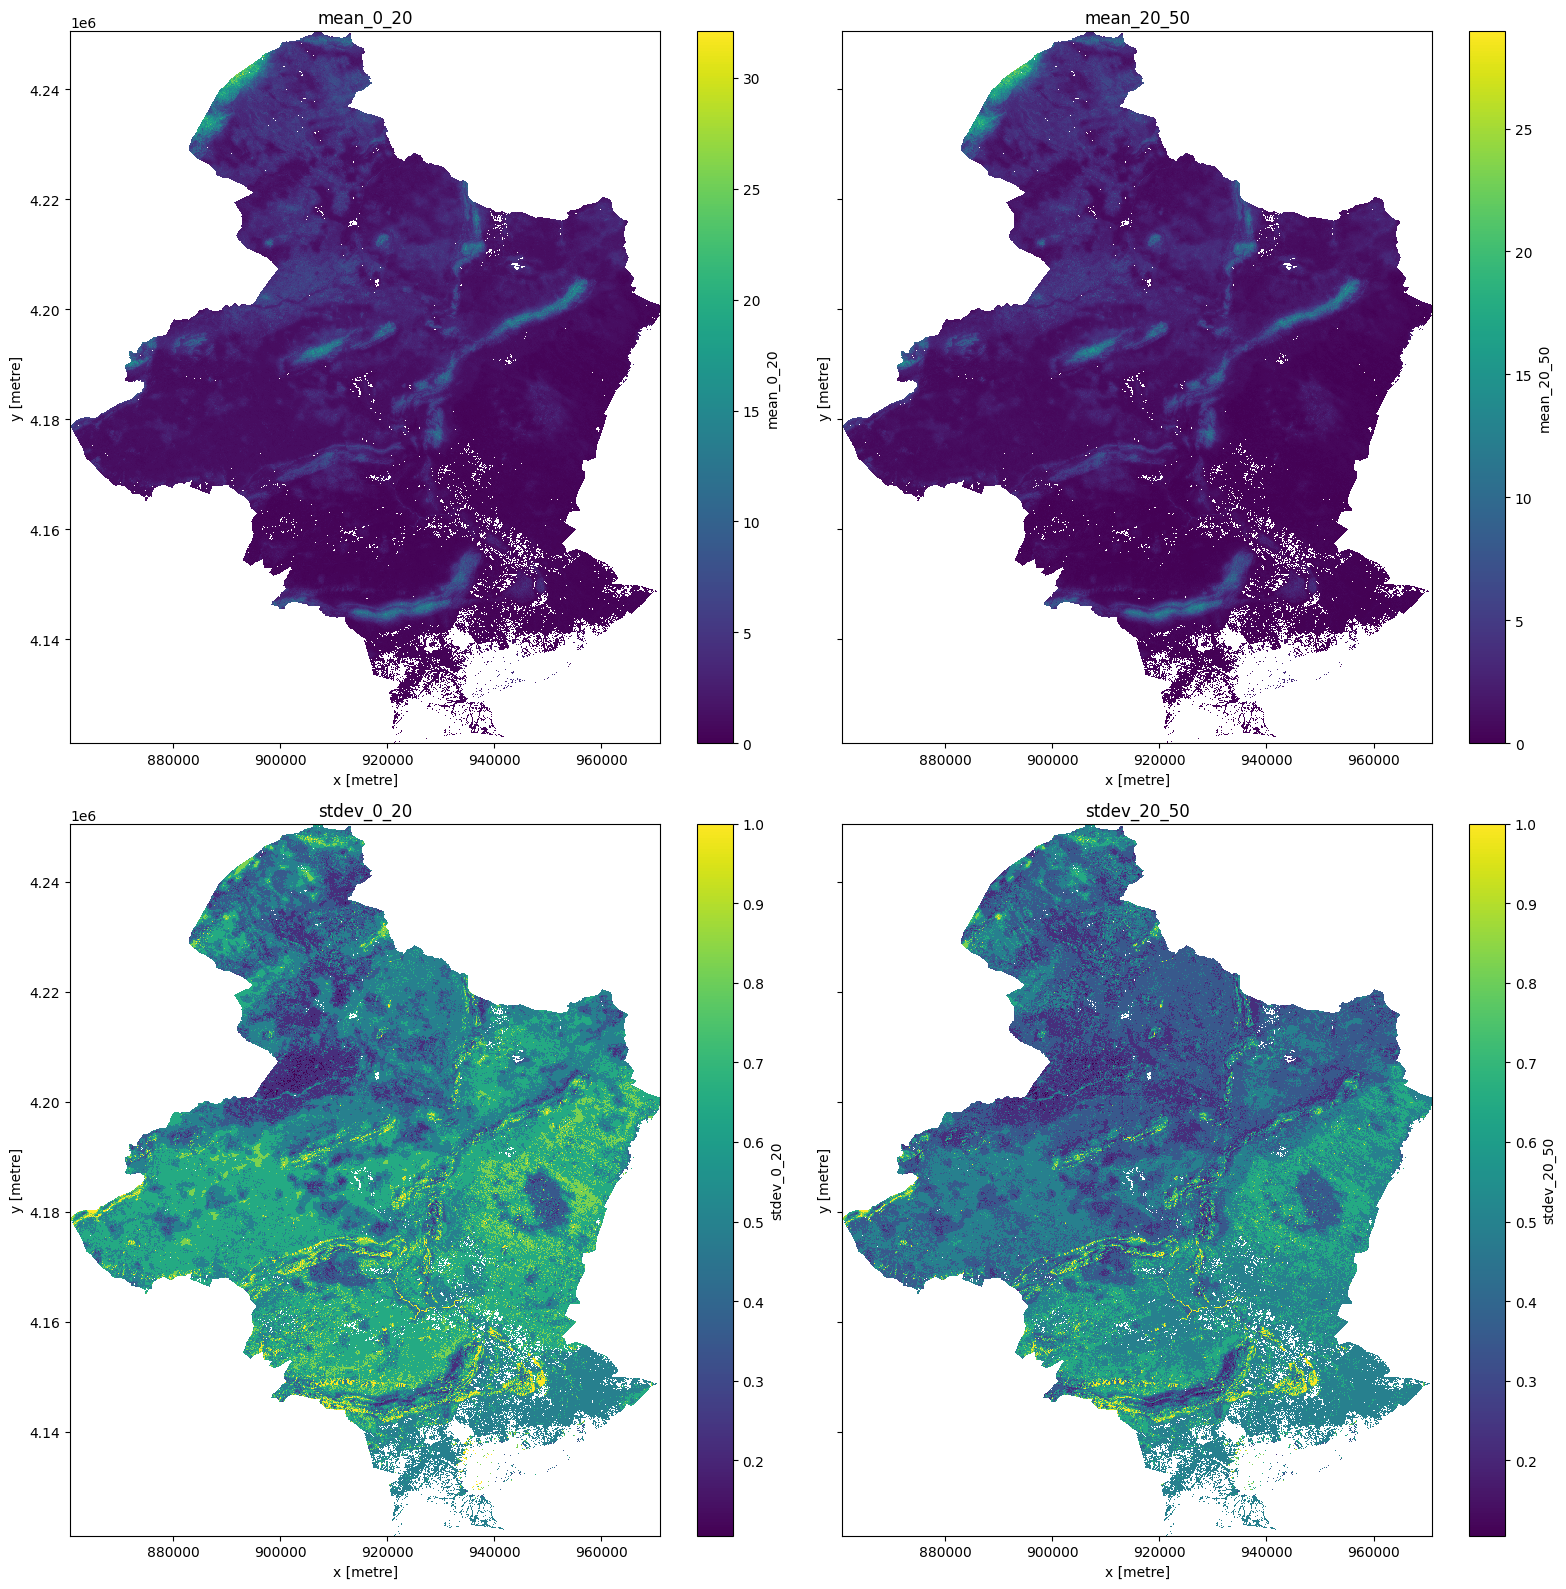

In [12]:
# Plot dataset variables in a 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
ds[list(ds.keys())[0]].plot(ax=ax[0, 0])
ds[list(ds.keys())[1]].plot(ax=ax[0, 1])
ds[list(ds.keys())[2]].clip(0,1).plot(ax=ax[1, 0])
ds[list(ds.keys())[3]].clip(0,1).plot(ax=ax[1, 1])
ax[0, 0].set_title(list(ds.keys())[0])
ax[0, 1].set_title(list(ds.keys())[1])
ax[1, 0].set_title(list(ds.keys())[2])
ax[1, 1].set_title(list(ds.keys())[3])
plt.tight_layout()

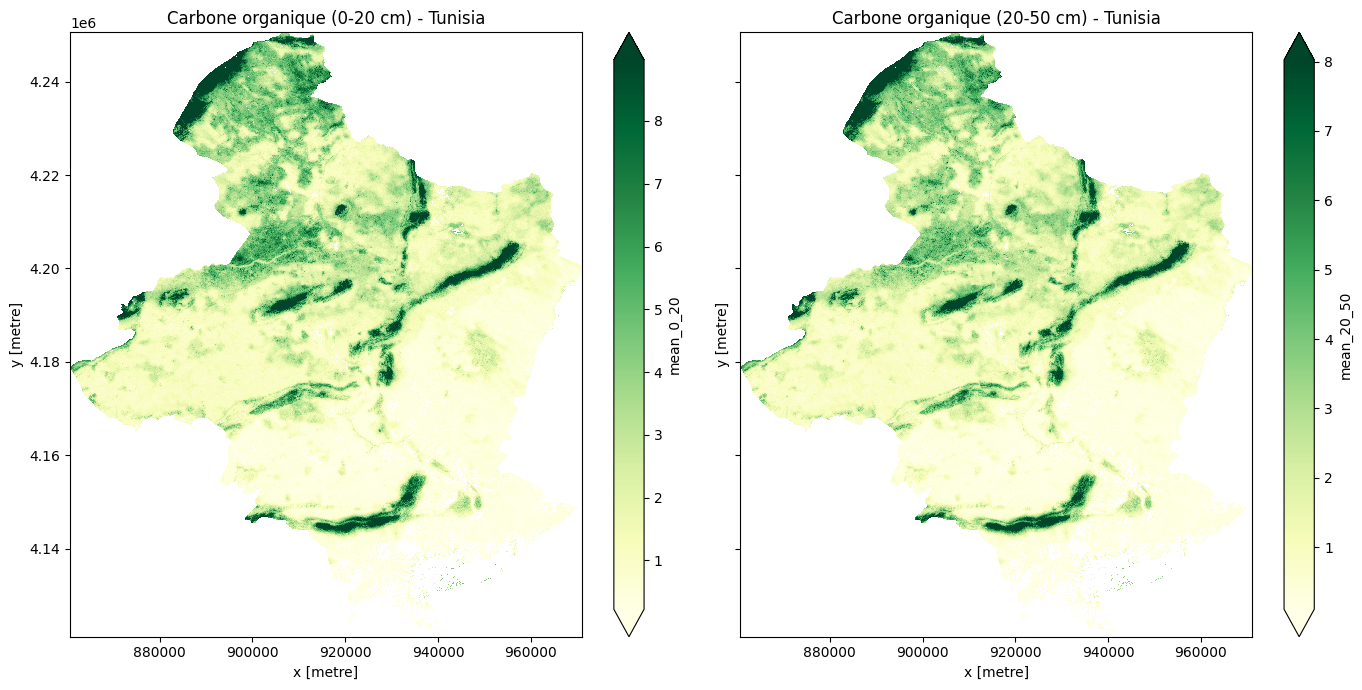

In [13]:
# Plot soil organic carbon (0-20 cm and 20-50 cm) for Tunisia in two side-by-side maps
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

ds.mean_0_20.plot(ax=ax[0], cmap='YlGn', robust=True)
ax[0].set_title("Carbone organique (0-20 cm) - Tunisia")

ds.mean_20_50.plot(ax=ax[1], cmap='YlGn', robust=True)
ax[1].set_title("Carbone organique (20-50 cm) - Tunisia")


# for a in ax:
#     a.set_aspect('equal')
#     country_shape = gpd.GeoSeries([country_feature["geometry"]], crs="EPSG:4326")
#     country_shape.boundary.plot(ax=a, color="black", linewidth=1.5)

plt.tight_layout()
plt.show()

### Weighted SOC concentration 

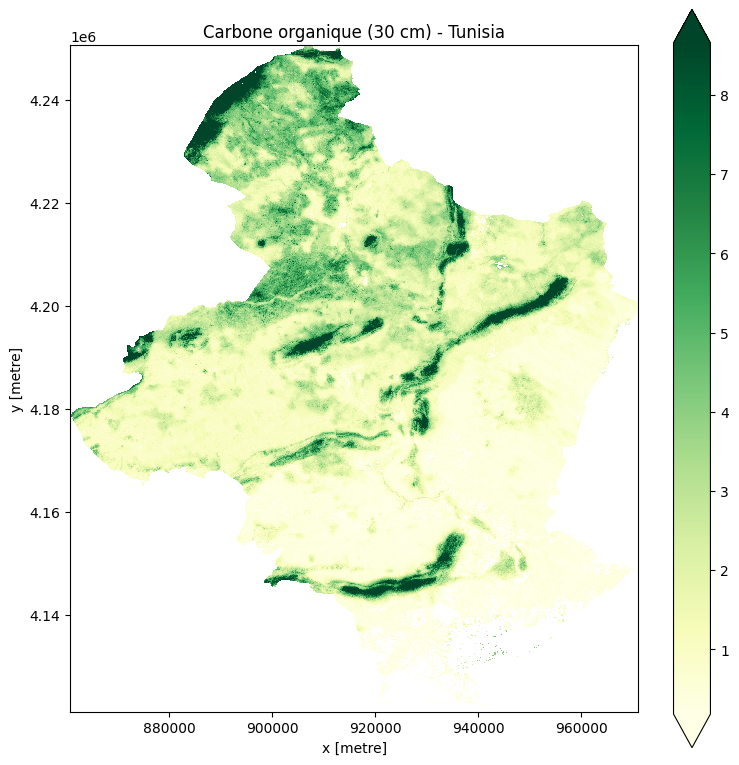

In [14]:
# Calculate and plot soil organic carbon at 30 cm depth for Tunisia using weighted interpolation
depth_30 = (ds.mean_20_50 * (30 - 20) + ds.mean_0_20 * (50 - 30)) / (50 - 20)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
depth_30.plot(ax=ax, cmap='YlGn', robust=True)
ax.set_title("Carbone organique (30 cm) - Tunisia")

ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [15]:
# Define parameters for data analysis
measurements = "classification"
time_range = ("2014", "2019")

initial_year = "2014"
target_year = "2019"

resolution = (-300, 300)
output_crs = "EPSG:6933"

output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [16]:
# Query and load dataset, then apply mask

query = {
         "time": time_range,
         "measurements": measurements,
         "resolution": resolution,
         "output_crs": output_crs,
          "x" : lon_range,
           "y" : lat_range
}

ds_lulc = dc.load(product="cci_landcover", **query)

ds_lulc = ds_lulc.where(ds_lulc != 0)

In [17]:
ds_lulc

<xarray.Dataset> Size: 4MB
Dimensions:         (time: 6, y: 432, x: 368)
Coordinates:
  * time            (time) datetime64[ns] 48B 2014-07-02T11:59:59.500000 ... ...
  * y               (y) float64 3kB 4.251e+06 4.25e+06 ... 4.122e+06 4.121e+06
  * x               (x) float64 3kB 8.608e+05 8.612e+05 ... 9.706e+05 9.71e+05
    spatial_ref     int32 4B 6933
Data variables:
    classification  (time, y, x) float32 4MB 11.0 11.0 11.0 ... 153.0 10.0 10.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [18]:
# Mask the dataset with the country polygon.
mask = xr_rasterize(geopolygon_gdf, ds_lulc)
ds_lulc = ds_lulc.where(mask)

In [19]:
text_font_dict = {
    "no data": "#000000",
    "cropland, rainfed": "#ffff00",
    "cropland, rainfed, herbaceous cover": "#ffff00",
    "cropland, rainfed, tree or shrub cover": "#ffff00",
    "cropland, irrigated or post-flooding": "#ffff00",
    "mosaic cropland/natural vegetation": "#ffff00",
    "mosaic natural vegetation/cropland": "#ffff00",
    "tree cover, broadleaved, evergreen, closed to open": "#054907",
    "tree cover, broadleaved, deciduous, closed to open": "#054907",
    "tree cover, broadleaved, deciduous, closed": "#054907",
    "tree cover, broadleaved, deciduous, open": "#054907",
    "tree cover, needleleaved, evergreen, closed to open": "#054907",
    "tree cover, needleleaved, evergreen, closed": "#054907",
    "tree cover, needleleaved, evergreen, open": "#054907",
    "tree cover, needleleaved, deciduous, closed to open": "#054907",
    "tree cover, needleleaved, deciduous, closed": "#054907",
    "tree cover, needleleaved, deciduous, open": "#054907",
    "tree cover, mixed leaf type": "#054907",
    "mosaic tree and shrub/herbaceous cover": "#054907",
    "mosaic herbaceous cover/tree and shrub": "#ffa500",
    "shrubland": "#ffa500",
    "shrubland, evergreen": "#ffa500",
    "shrubland, deciduous": "#ffa500",
    "grassland": "#ffa500",
    "lichens and mosses": "#ffa500",
    "sparse vegetation": "#ffa500",
    "sparse tree": "#ffa500",
    "sparse shrub": "#ffa500",
    "sparse herbaceous cover": "#ffa500",
    "tree cover, flooded, fresh or brakish water": "#af51ed",
    "tree cover, flooded, saline water": "#af51ed",
    "shrub or herbaceous cover, flooded, fresh/saline/brakish water": "#af51ed",
    "urban areas": "#dc143c",
    "bare areas": "#d6d4b6",
    "consolidated bare areas": "#d6d4b6",
    "unconsolidated bare areas": "#d6d4b6",
    "water bodies": "#069af3",
    "permanent snow and ice": "#d6d4b6",
}

In [24]:
country = "Tunisia"
# # Extract classified data
ds_cci = ds_lulc["classification"]
for i in range(len(ds_cci.time)):
    singleTimestamp = ds_cci.isel(time=i)
    year = singleTimestamp.time.dt.strftime('%Y').data
    fname = f"{output_dir}/{year}_{country.replace(' ', '')}_ipcc_lulc.tif"
    print(f'Writing {fname}')
    write_cog(singleTimestamp, fname=fname, overwrite=True)

Writing results/2014_Tunisia_ipcc_lulc.tif
Writing results/2015_Tunisia_ipcc_lulc.tif
Writing results/2016_Tunisia_ipcc_lulc.tif
Writing results/2017_Tunisia_ipcc_lulc.tif
Writing results/2018_Tunisia_ipcc_lulc.tif
Writing results/2019_Tunisia_ipcc_lulc.tif


In [26]:
# then reclassify the dataset and apply a mask to the result.
lulc_labels = ["Forest", "Grassland", "Cropland", "Wetland", "Artificial area", "Bare land", "Water"]
lulc_classes = [1, 2, 3, 4, 5, 6, 7]
lulc_colors = ["#054907", "#ffa500", "#ffff00", "#af51ed", "#dc143c", "#d6d4b6", "#069af3"]


forest_classes = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100]
grassland_classes = [110, 120, 121, 122, 130, 140, 150, 151, 152, 153]
cropland_classes = [10, 11, 12, 20, 30, 40]
wetland_classes = [160, 170, 180]
artificial_classes = [190]
bare_land_classes = [200, 201, 202, 220]
water_classes = [210]


reclassification_condition = [
    ds_cci.isin(forest_classes),
    ds_cci.isin(grassland_classes),
    ds_cci.isin(cropland_classes),
    ds_cci.isin(wetland_classes),
    ds_cci.isin(artificial_classes),
    ds_cci.isin(bare_land_classes),
    ds_cci.isin(water_classes)
]


ds_lulc_df = xr.DataArray(
    data=np.select(reclassification_condition, lulc_classes, default=np.nan),
    coords={"time": ds_lulc.time, "y": ds_lulc.y, "x": ds_lulc.x},
    dims=["time", "y", "x"]
).astype(ds_cci.dtype)

ds_lulc_df = ds_lulc_df.where(mask)

print(ds_lulc_df)

<xarray.DataArray (time: 6, y: 432, x: 368)> Size: 4MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,

In [27]:
# Iterate the reclassified land use/land cover data
for i in range(len(ds_lulc_df.time)):

    singleTimestamp = ds_lulc_df.isel(time=i)
    year = singleTimestamp.time.dt.strftime('%Y').data

    fname = f"{output_dir}/{year}_{country.replace(' ', '')}_reclassified_lulc.tif"
    print(f'Writing {fname}')

    write_cog(singleTimestamp, fname=fname, overwrite=True)

Writing results/2014_Tunisia_reclassified_lulc.tif
Writing results/2015_Tunisia_reclassified_lulc.tif
Writing results/2016_Tunisia_reclassified_lulc.tif
Writing results/2017_Tunisia_reclassified_lulc.tif
Writing results/2018_Tunisia_reclassified_lulc.tif
Writing results/2019_Tunisia_reclassified_lulc.tif


/opt/venv/lib/python3.12/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


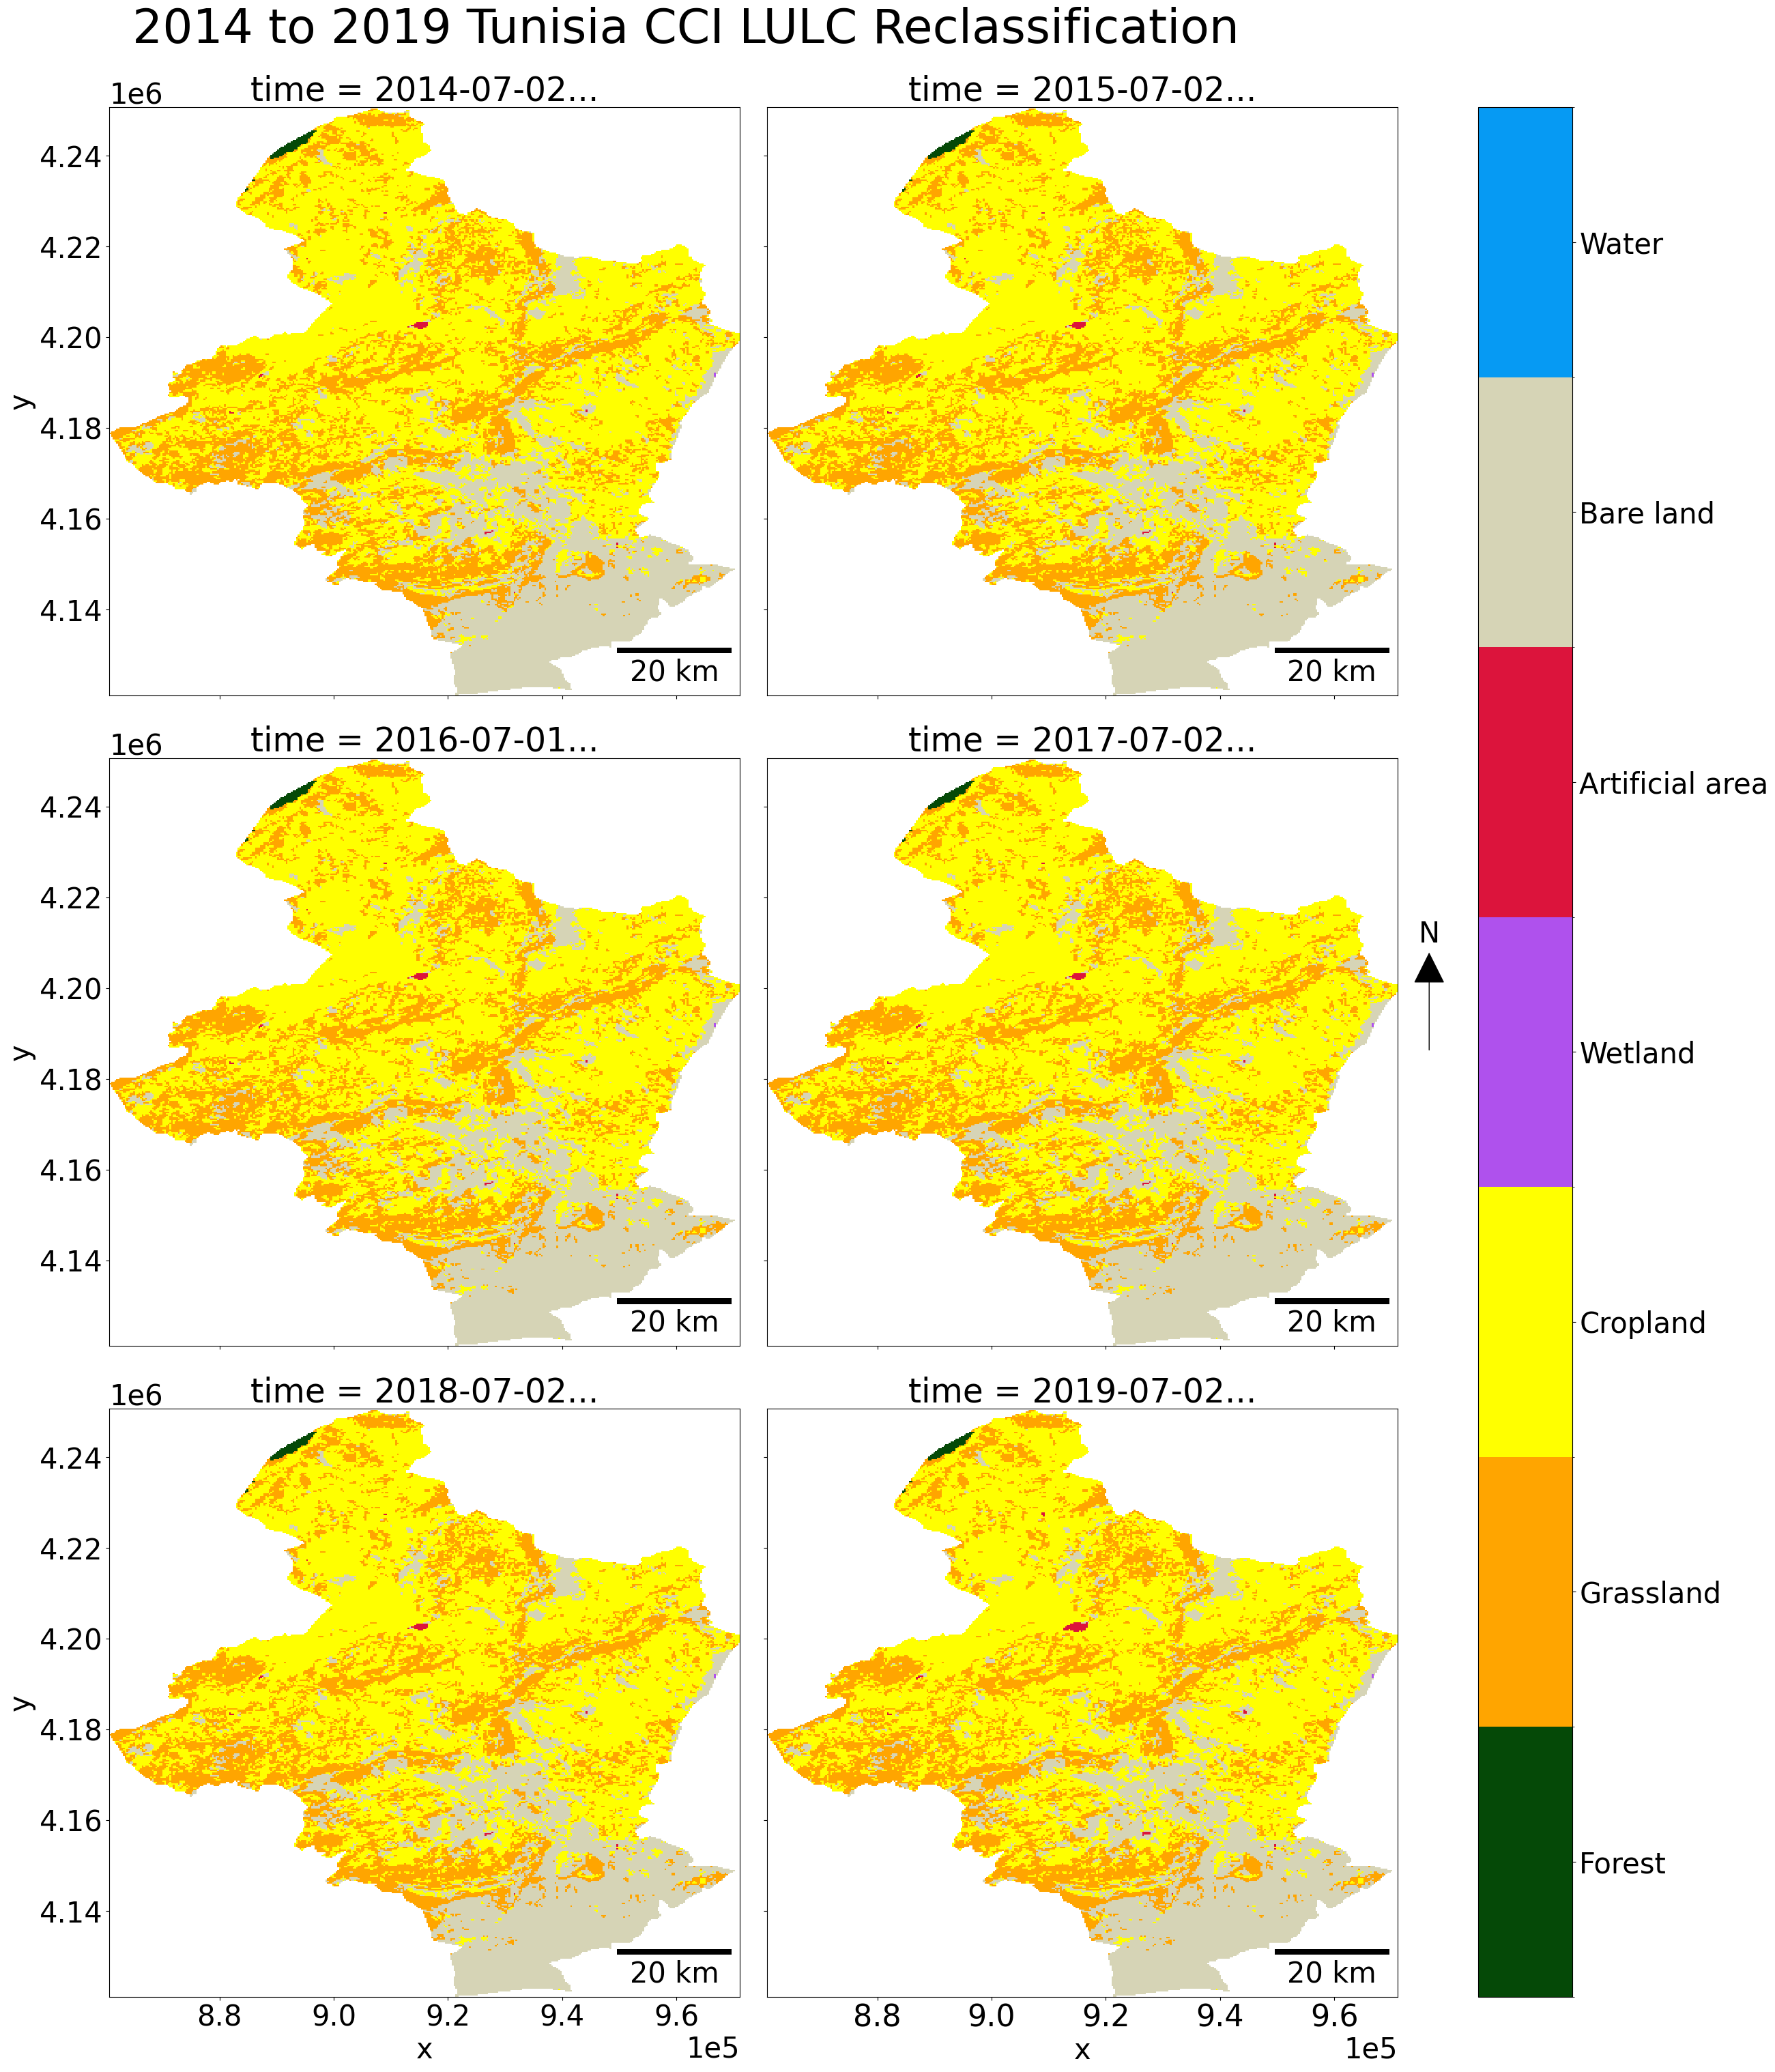

In [28]:
# Plot reclassified LULC data for each time step with custom settings

plt.rcParams.update({'font.size': 30})

cmap = mcolors.ListedColormap(colors=lulc_colors, N=len(lulc_classes))
bounds = np.arange(min(lulc_classes) - 0.5, max(lulc_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ncols = 2

no_of_subplots = len(ds_lulc.time.values)

figure_width = 13 * ncols
figure_length = 10 * (no_of_subplots/ncols)

fig = ds_lulc_df.plot(col="time", col_wrap=ncols, add_colorbar=False, figsize=(figure_width,figure_length), cmap=cmap, norm=norm)

fig.fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} CCI LULC Reclassification", x=0.4, y=1.02, size=50)

fig.set_titles(template='{coord} = {value}', size=35, maxchar=20)

for i, ax in enumerate(fig.axs.flat):

    ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))

    ax.add_artist(ScaleBar(dx=1, location="lower right"))

    if i == 3:
        # Add a north arrow to the last subplot in the figure.
        x, y, arrow_length = 1.05, 0.5, 0.2
        ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                    arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.5', facecolor='black'),
                    ha='center', va='center', fontsize=30,
                    xycoords=ax.transAxes)

cbar = plt.colorbar(fig._mappables[-1], ax=fig.axs, ticks=lulc_classes)
cbar.set_ticklabels(lulc_labels)
ax.tick_params(labelsize=32)

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_lulc_reclassification.png")
plt.show()

In [29]:
# Define labels, classes, colors, and dictionary for change classification (Degradation, Stable, Improvement).
change_labels = ["Degradation", "Stable", "Improvement"]
change_classes = [-1, 0, 1]
change_colors = [ "red", "orange", "green"]
change_class_dict = dict(zip(change_labels, change_classes))

In [30]:
t0 = ds_lulc_df.sel(time=initial_year).squeeze().values
tn = ds_lulc_df.sel(time=target_year).squeeze().values

In [31]:
# Create a change array and classify the transitions between land use states as Degradation, Stable, or Improvement.
change = np.full(shape=t0.shape, fill_value=change_class_dict["Stable"])
change = np.where((((t0 == 1) & (tn == 2)) |
                   ((t0 == 1) & (tn == 3)) |
                   ((t0 == 1) & (tn == 4)) |
                   ((t0 == 1) & (tn == 5)) |
                   ((t0 == 1) & (tn == 6)) |
                   ((t0 == 2) & (tn == 3)) |
                   ((t0 == 2) & (tn == 5)) |
                   ((t0 == 2) & (tn == 6)) |
                   ((t0 == 3) & (tn == 5)) |
                   ((t0 == 3) & (tn == 6)) |
                   ((t0 == 4) & (tn == 3)) |
                   ((t0 == 4) & (tn == 5)) |
                   ((t0 == 4) & (tn == 6)) |
                   ((t0 == 6) & (tn == 5))
                  ), change_class_dict["Degradation"], change)



change = np.where((((t0 == 2) & (tn == 1)) |
                   ((t0 == 3) & (tn == 1)) |
                   ((t0 == 3) & (tn == 2)) |
                   ((t0 == 3) & (tn == 4)) |
                   ((t0 == 4) & (tn == 1)) |
                   ((t0 == 5) & (tn == 1)) |
                   ((t0 == 5) & (tn == 2)) |
                   ((t0 == 5) & (tn == 3)) |
                   ((t0 == 5) & (tn == 4)) |
                   ((t0 == 5) & (tn == 6)) |
                   ((t0 == 6) & (tn == 1)) |
                   ((t0 == 6) & (tn == 2)) |
                   ((t0 == 6) & (tn == 3)) |
                   ((t0 == 6) & (tn == 4))
                  ), change_class_dict["Improvement"], change)


ds_change = xr.DataArray(data=change,
                         coords={"y": ds_lulc_df.y, "x": ds_lulc_df.x},
                         dims=["y", "x"]).astype(ds_lulc_df.dtype).where(mask)

/opt/venv/lib/python3.12/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


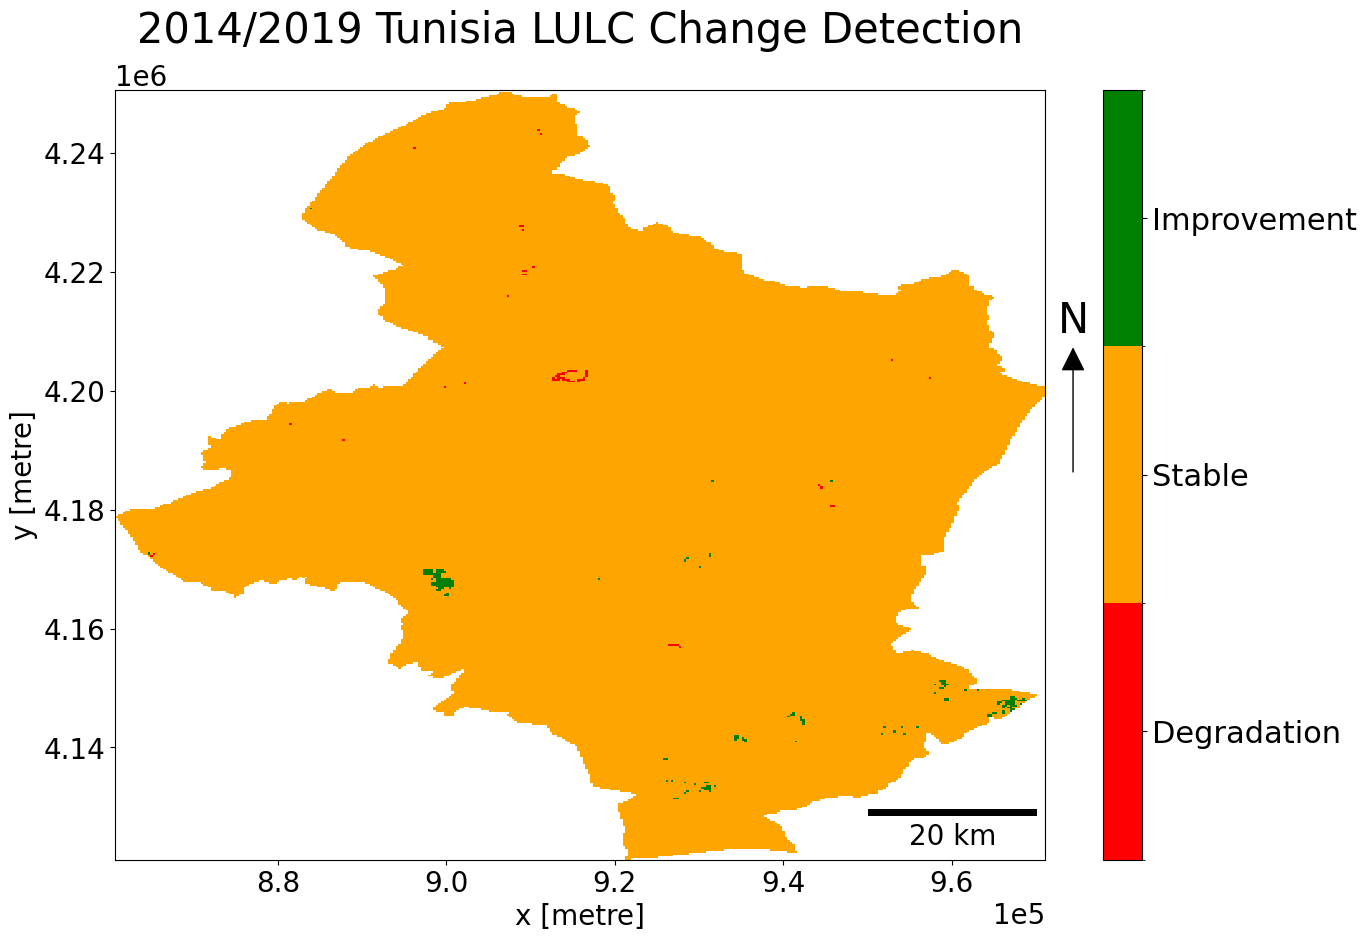

In [32]:
# Plot LULC change detection between two years
plt.rcParams.update({'font.size': 20})

cmap = mcolors.ListedColormap(colors=change_colors, N=len(change_classes))
bounds = np.arange(min(change_classes) - 0.5, max(change_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig , ax = plt.subplots(figsize=(15, 10))
im = ds_change.plot.imshow(add_colorbar=False, ax=ax, cmap=cmap, norm=norm)

ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))

ax.add_artist(ScaleBar(dx=1, location="lower right"))

x, y, arrow_length = 1.03, 0.5, 0.2
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
            arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
            ha='center', va='center', fontsize=30,
            xycoords=ax.transAxes)

plt.title(f"{initial_year}/{target_year} {country} LULC Change Detection", y=1.05, ha="center", size=30)

cbar = plt.colorbar(im, ticks=change_classes)
cbar.set_ticklabels(change_labels)
cbar.ax.tick_params(labelsize=22)

plt.show()

In [33]:
def make_pretty(df, title):
    return df.set_caption(title)

lulc_labels = ["Forest", "Grassland", "Croplands", "Wetlands", "Artificial areas", "Bare lands", "Water bodies"]

row_labels = lulc_labels
column_labels = lulc_labels

ref_carbon_conversion_matrix = pd.DataFrame(None, index=row_labels, columns=column_labels, dtype=object)

ref_carbon_conversion_matrix.index.name = "Year of follow up <br> Initial Year"

transitions = {
    ("Forest", "Forest"): ("Stable", 1),
    ("Forest", "Grassland"): ("Stable", 1),
    ("Forest", "Croplands"): ("Declining", "f"),
    ("Forest", "Wetlands"): ("Stable", 1),
    ("Forest", "Artificial areas"): ("Declining", 0.1),
    ("Forest", "Bare lands"): ("Declining", 0.1),
    ("Forest", "Water bodies"): ("Stable", 1),

    ("Grassland", "Forest"): ("Stable", 1),
    ("Grassland", "Grassland"): ("Stable", 1),
    ("Grassland", "Croplands"): ("Declining", "f"),
    ("Grassland", "Wetlands"): ("Stable", 1),
    ("Grassland", "Artificial areas"): ("Declining", 0.1),
    ("Grassland", "Bare lands"): ("Declining", 0.1),
    ("Grassland", "Water bodies"): ("Stable", 1),

    ("Croplands", "Forest"): ("Improving", "1/f"),
    ("Croplands", "Grassland"): ("Improving", "1/f"),
    ("Croplands", "Croplands"): ("Stable", 1),
    ("Croplands", "Wetlands"): ("Improving", "1/0.71"),
    ("Croplands", "Artificial areas"): ("Declining", 0.1),
    ("Croplands", "Bare lands"): ("Declining", 0.1),
    ("Croplands", "Water bodies"): ("Stable", 1),

    ("Wetlands", "Forest"): ("Stable", 1),
    ("Wetlands", "Grassland"): ("Stable", 1),
    ("Wetlands", "Croplands"): ("Declining", 0.71),
    ("Wetlands", "Wetlands"): ("Stable", 1),
    ("Wetlands", "Artificial areas"): ("Declining", 0.1),
    ("Wetlands", "Bare lands"): ("Declining", 0.1),
    ("Wetlands", "Water bodies"): ("Stable", 1),

    ("Artificial areas", "Forest"): ("Improving", 2),
    ("Artificial areas", "Grassland"): ("Improving", 2),
    ("Artificial areas", "Croplands"): ("Improving", 2),
    ("Artificial areas", "Wetlands"): ("Improving", 2),
    ("Artificial areas", "Artificial areas"): ("Stable", 1),
    ("Artificial areas", "Bare lands"): ("Stable", 1),
    ("Artificial areas", "Water bodies"): ("Stable", 1),

    ("Bare lands", "Forest"): ("Improving", 2),
    ("Bare lands", "Grassland"): ("Improving", 2),
    ("Bare lands", "Croplands"): ("Improving", 2),
    ("Bare lands", "Wetlands"): ("Improving", 2),
    ("Bare lands", "Artificial areas"): ("Stable", 1),
    ("Bare lands", "Bare lands"): ("Stable", 1),
    ("Bare lands", "Water bodies"): ("Stable", 1),

    ("Water bodies", "Forest"): ("Stable", 1),
    ("Water bodies", "Grassland"): ("Stable", 1),
    ("Water bodies", "Croplands"): ("Stable", 1),
    ("Water bodies", "Wetlands"): ("Stable", 1),
    ("Water bodies", "Artificial areas"): ("Stable", 1),
    ("Water bodies", "Bare lands"): ("Stable", 1),
    ("Water bodies", "Water bodies"): ("Stable", 1),
}

for (src, dst), (label, value) in transitions.items():
    ref_carbon_conversion_matrix.loc[src, dst] = label

ref_carbon_conversion_matrix.reset_index(inplace=True)

def lulc_set_background_color(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)  # Empty DataFrame for styles

    for index in df.index:
        for col in df.columns[1:]:  # Skip the index column
            value = df.loc[index, col]
            if value == "Stable":
                styles.loc[index, col] = "background-color: orange;"
            elif value == "Declining":
                styles.loc[index, col] = "background-color: red;"
            elif value == "Improving":
                styles.loc[index, col] = "background-color: green;"

    return styles


ref_carbon_conversion_matrix = (
    ref_carbon_conversion_matrix
    .style
    .hide(axis="index")
    .apply(lulc_set_background_color, axis=None)
    .pipe(make_pretty, title="Carbon Conversion Change Matrix")
)


output_dir = './results'
country = "Tunisia"
ref_carbon_conversion_matrix.data.to_csv(f"{output_dir}/{country.replace(' ', '')}_reference_carbon_conversion_matrix.csv", index=False)


display(ref_carbon_conversion_matrix)

/opt/venv/lib/python3.12/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


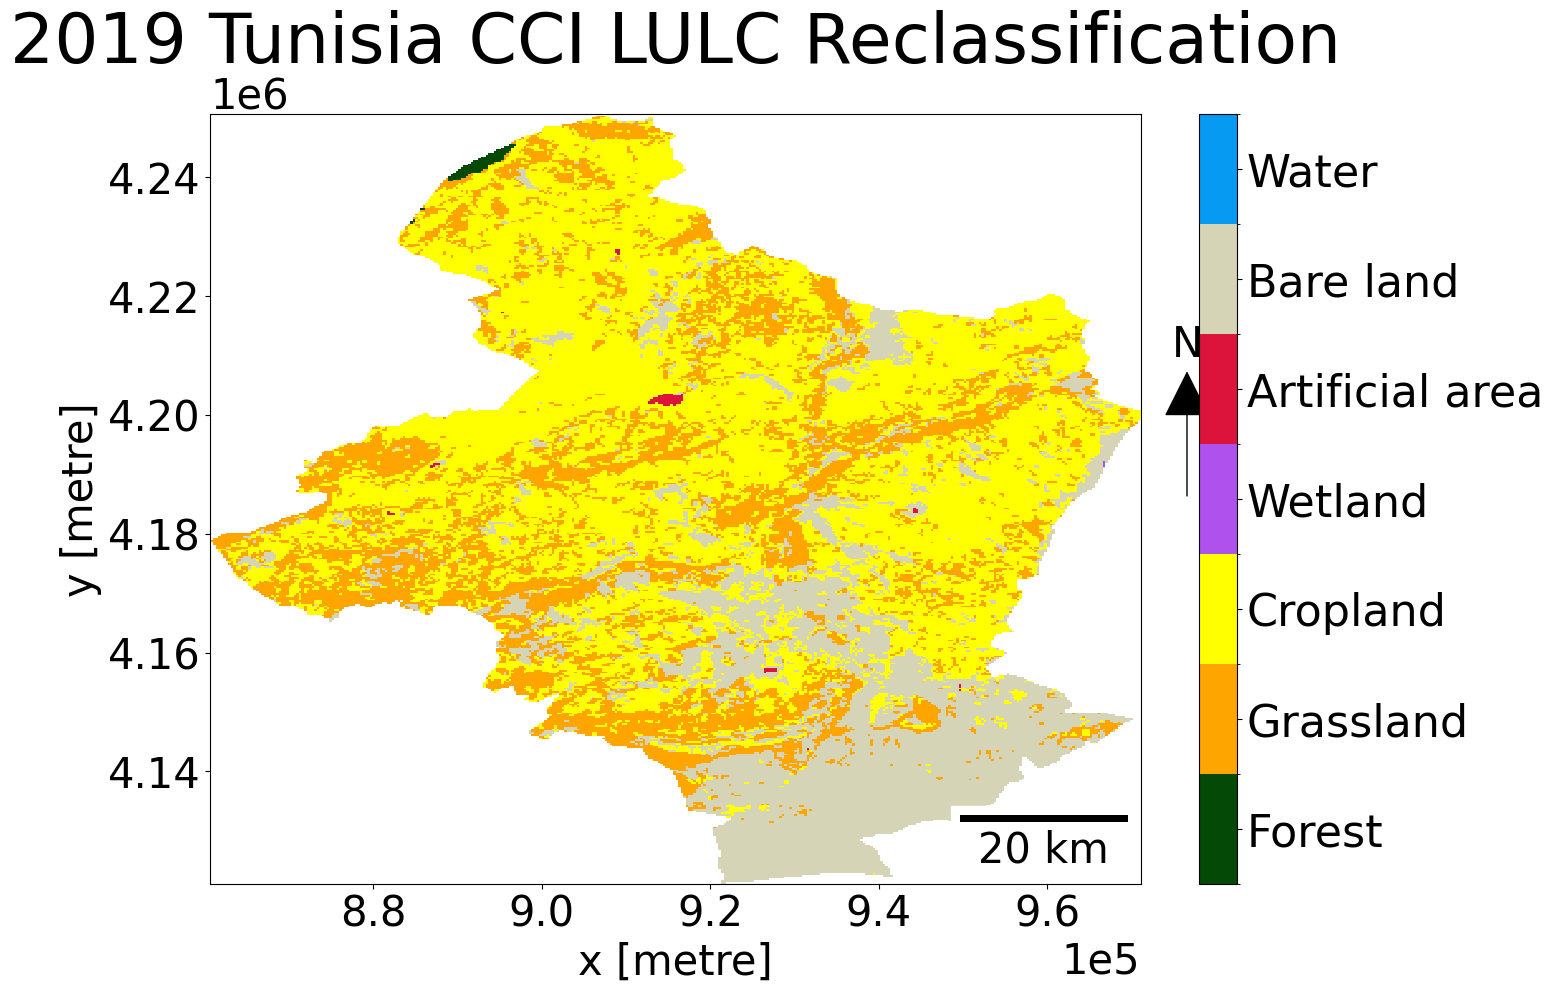

In [34]:
# Visualize the LULC data
plt.rcParams.update({'font.size': 30})

# then reclassify the dataset and apply a mask to the result.
lulc_labels = ["Forest", "Grassland", "Cropland", "Wetland", "Artificial area", "Bare land", "Water"]
lulc_classes = [1, 2, 3, 4, 5, 6, 7]
lulc_colors = ["#054907", "#ffa500", "#ffff00", "#af51ed", "#dc143c", "#d6d4b6", "#069af3"]

cmap = mcolors.ListedColormap(colors=lulc_colors, N=len(lulc_classes))
bounds = np.arange(min(lulc_classes) - 0.5, max(lulc_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ds_lulc_2019 = ds_lulc_df.sel(time='2019')
fig, ax = plt.subplots(figsize=(15, 10))

ds_lulc_2019.plot(ax=ax, add_colorbar=False, cmap=cmap, norm=norm)

ax.set_title(f"{target_year} {country} CCI LULC Reclassification", fontsize=50)

ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))

ax.add_artist(ScaleBar(dx=1, location="lower right"))

x, y, arrow_length = 1.05, 0.5, 0.2
ax.annotate('N', xy=(x, y), xytext=(x, y + arrow_length),
            arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.5', facecolor='black'),
            ha='center', va='center', fontsize=30,
            xycoords=ax.transAxes)


cbar = plt.colorbar(ax.collections[0], ax=ax, ticks=lulc_classes)
cbar.set_ticklabels(lulc_labels)
cbar.ax.tick_params(labelsize=32)


plt.savefig(f"{output_dir}/{target_year}_{country.replace(' ', '')}_lulc_reclassification.png")
plt.show()


Resampled Depth Shape: (1, 479, 408)
LULC Shape: (1, 432, 368)


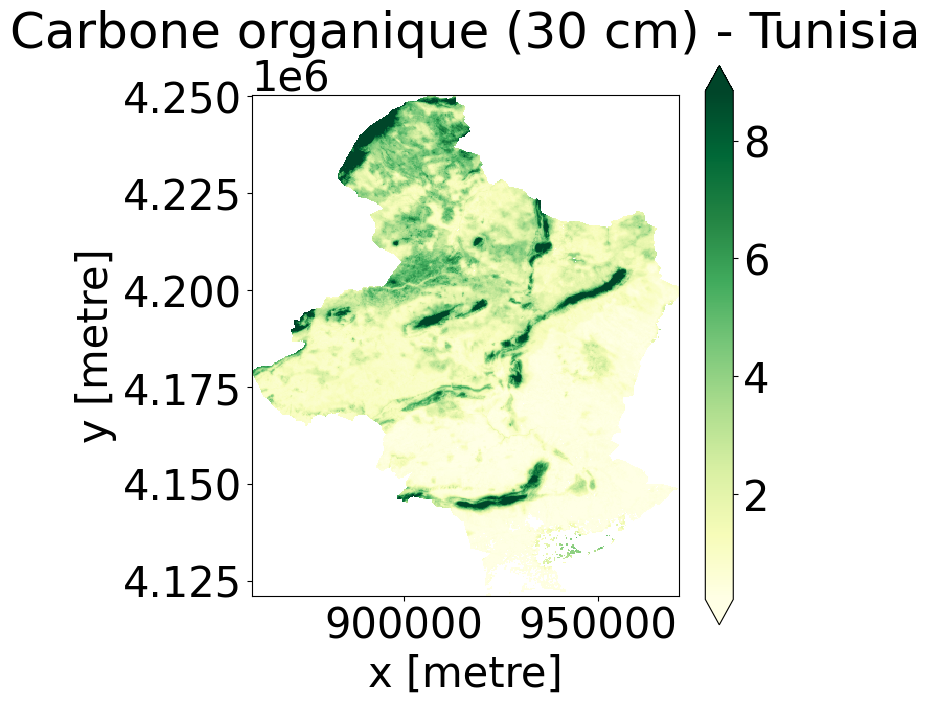

In [35]:
# Calulate and visualize resampled depth of Soil Organic Carbon at 30 cm depth
if 'mean_0_20' in ds.data_vars and 'mean_20_50' in ds.data_vars:

    depth_30 = (ds['mean_20_50'] * (30 - 20) + ds['mean_0_20'] * (50 - 30)) / (50 - 20)

    depth_30_resampled = depth_30.coarsen(
        x=depth_30.shape[1] // ds_lulc_2019.shape[1],
        y=depth_30.shape[2] // ds_lulc_2019.shape[2],
        boundary='trim'
    ).mean()


    print("Resampled Depth Shape:", depth_30_resampled.shape)
    print("LULC Shape:", ds_lulc_2019.shape)


    fig, ax = plt.subplots(1, 1, figsize=(8, 8))


    depth_30_resampled.plot(ax=ax, cmap='YlGn', robust=True)
    ax.set_title("Carbone organique (30 cm) - Tunisia")
    # ax.set_xlim(minx, maxx)
    # ax.set_ylim(miny, maxy)

    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Expected variables 'mean_0_20' and 'mean_20_50' are not present in the dataset.")


In [36]:
# Coarsen the Carbon dataset

print("Current Carbon Dataset Dimensions:", depth_30.dims)

print("Carbon Dataset Dimensions (no renaming needed):", depth_30.dims)

new_y = 916  # Target height
new_x = 598  # Target width

depth_30_resampled = depth_30.coarsen(
    y=depth_30.shape[1] // new_y,
    x=depth_30.shape[2] // new_x,
    boundary='trim'
).mean()

print("Resampled Carbon Shape:", depth_30_resampled.shape)

Current Carbon Dataset Dimensions: ('time', 'y', 'x')
Carbon Dataset Dimensions (no renaming needed): ('time', 'y', 'x')
Resampled Carbon Shape: (1, 1078, 612)


In [37]:
# Print the dimensions of the resampled depth_30 dataset
print("Dimensions de depth_30_resampled :", depth_30_resampled.dims)

Dimensions de depth_30_resampled : ('time', 'y', 'x')


In [38]:
if 'ds_lulc_2019' not in locals():
    raise NameError("ds_lulc_2019 n'est pas défini. Veuillez le définir avant d'exécuter ce code.")

depth_30_resampled = depth_30_resampled.interp(
    y=ds_lulc_2019.coords['y'],  # Remplacez 'y' par 'latitude' si nécessaire
    x=ds_lulc_2019.coords['x'],  # Remplacez 'x' par 'longitude' si nécessaire
    method='linear'
)

print("Resampled Carbon Shape:", depth_30_resampled.shape)

lulc_flat = ds_lulc_2019.values.flatten()  # (916, 598) -> (546048,)
carbon_flat = depth_30_resampled.values.flatten()  # Should now also be (546048,)

print("Flattened LULC Length:", len(lulc_flat))
print("Flattened Carbon Length:", len(carbon_flat))

data = pd.DataFrame({
    'LULC Class': lulc_flat,
    'Carbon Value': carbon_flat
})

# Remove rows where LULC class is NaN or 0 (if 0 represents no data)
data = data[(data['LULC Class'].notna()) & (data['LULC Class'] != 0)]

print("DataFrame Shape after Filtering:", data.shape)

range_values = data.groupby('LULC Class')['Carbon Value'].agg(['min', 'max']).reset_index()

print(range_values)

Resampled Carbon Shape: (1, 432, 368)
Flattened LULC Length: 158976
Flattened Carbon Length: 158976
DataFrame Shape after Filtering: (82607, 2)
   LULC Class        min        max
0         1.0  14.002772  24.448997
1         2.0   0.144863  21.067757
2         3.0   0.109602  21.856492
3         4.0        NaN        NaN
4         5.0   0.516804   6.248030
5         6.0   0.070114  12.788956


In [39]:
# Prints the coordinates of the 'ds_lulc_2019' dataset
print(ds_lulc_2019.coords)

Coordinates:
  * time         (time) datetime64[ns] 8B 2019-07-02T11:59:59.500000
  * y            (y) float64 3kB 4.251e+06 4.25e+06 ... 4.122e+06 4.121e+06
  * x            (x) float64 3kB 8.608e+05 8.612e+05 ... 9.706e+05 9.71e+05
    spatial_ref  int32 4B 6933


In [40]:
# Prints the coordinates of the 'ds_lulc_2019' dataset and resamples 'depth_30' to match its grid.
# Flattens both LULC and Carbon datasets, filters out invalid data, and calculates min/max carbon values for each LULC class

depth_30_resampled = depth_30_resampled.interp(
    y=ds_lulc_2019.coords['y'],
    x=ds_lulc_2019.coords['x'],
    method='linear'
)

print("Resampled Carbon Shape:", depth_30_resampled.shape)

lulc_flat = ds_lulc_2019.values.flatten()  # (916, 598) -> (546048,)
carbon_flat = depth_30_resampled.values.flatten()  # Should now also be (546048,)

print("Flattened LULC Length:", len(lulc_flat))
print("Flattened Carbon Length:", len(carbon_flat))

data = pd.DataFrame({
    'LULC Class': lulc_flat,
    'Carbon Value': carbon_flat
})

data = data[(data['LULC Class'].notna()) & (data['LULC Class'] != 0)]

print("DataFrame Shape after Filtering:", data.shape)

range_values = data.groupby('LULC Class')['Carbon Value'].agg(['min', 'max']).reset_index()

print(range_values)

Resampled Carbon Shape: (1, 432, 368)
Flattened LULC Length: 158976
Flattened Carbon Length: 158976
DataFrame Shape after Filtering: (82607, 2)
   LULC Class        min        max
0         1.0  14.002772  23.685298
1         2.0   0.144863  19.698634
2         3.0   0.109602  21.856492
3         4.0        NaN        NaN
4         5.0   0.516804   6.248030
5         6.0   0.077930  12.788956


In [41]:
print(data.head())

print("Unique Carbon Values:", data['Carbon Value'].unique())

print("Number of NaN values in Carbon Value:", data['Carbon Value'].isna().sum())

print(data['LULC Class'].value_counts())

     LULC Class  Carbon Value
520         6.0           NaN
521         2.0      3.528117
522         2.0      3.620280
523         2.0      3.789700
524         3.0      3.563071
Unique Carbon Values: [       nan 3.52811702 3.6202804  ... 0.32951002 0.31016427 0.29401324]
Number of NaN values in Carbon Value: 7228
LULC Class
3.0    43486
2.0    20719
6.0    18134
1.0      160
5.0      105
4.0        3
Name: count, dtype: int64


In [42]:
print("Resampled Carbon Values:")
print(depth_30_resampled)
print("Non-NaN values in Resampled Carbon:", depth_30_resampled.count())

print("Shape of LULC Dataset:", ds_lulc_2019.shape)
print("Shape of Resampled Carbon Dataset:", depth_30_resampled.shape)


Resampled Carbon Values:
<xarray.DataArray (time: 1, y: 432, x: 368)> Size: 1MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 8B 2009-01-01
    spatial_ref  int32 4B 6933
  * y            (y) float64 3kB 4.251e+06 4.25e+06 ... 4.122e+06 4.121e+06
  * x            (x) float64 3kB 8.608e+05 8.612e+05 ... 9.706e+05 9.71e+05
Non-NaN values in Resampled Carbon: <xarray.DataArray ()> Size: 8B
array(75400)
Coordinates:
    spatial_ref  int32 4B 6933
Shape of LULC Dataset: (1, 432, 368)
Shape of Resampled Carbon Dataset: (1, 432, 368)


In [43]:
print("Original Carbon Values (depth_30):")
print(depth_30)
print("Non-NaN values in Original Carbon:", depth_30.count())

Original Carbon Values (depth_30):
<xarray.DataArray (time: 1, y: 4314, x: 3676)> Size: 63MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 8B 2009-01-01
  * y            (y) float64 35kB 4.121e+06 4.121e+06 ... 4.251e+06 4.251e+06
  * x            (x) float64 29kB 8.607e+05 8.608e+05 ... 9.71e+05 9.71e+05
    spatial_ref  int32 4B 6933
Non-NaN values in Original Carbon: <xarray.DataArray ()> Size: 8B
array(7738958)
Coordinates:
    spatial_ref  int32 4B 6933


In [44]:
depth_30_resampled = depth_30.coarsen(
    x=depth_30.shape[1] // ds_lulc_2019.shape[1],
    y=depth_30.shape[2] // ds_lulc_2019.shape[2],
    boundary='trim'
).mean()

print("Resampled Carbon Shape:", depth_30_resampled.shape)

Resampled Carbon Shape: (1, 479, 408)


In [45]:
# Calculates the factors for resampling based on the target dimensions, then resamples the 'depth_30' dataset by coarsening.
factor_y = depth_30.shape[1] // 916
factor_x = depth_30.shape[2] // 598

depth_30_resampled = depth_30.coarsen(
    y=factor_y,
    x=factor_x,
    boundary='trim'
).mean()

print("Resampled Carbon Shape:", depth_30_resampled.shape)


Resampled Carbon Shape: (1, 1078, 612)


In [46]:
# Creates target longitude and latitude arrays for interpolation
target_longitude = np.linspace(depth_30.coords['x'].min(), depth_30.coords['x'].max(), len(ds_lulc_2019.x.values))
target_latitude = np.linspace(depth_30.coords['y'].min(), depth_30.coords['y'].max(), len(ds_lulc_2019.y.values))

depth_30_resampled = depth_30.interp(x=target_longitude, y=target_latitude)

print("Resampled Carbon Shape after interpolation:", depth_30_resampled.shape)
print(depth_30.coords)


Resampled Carbon Shape after interpolation: (1, 432, 368)
Coordinates:
  * time         (time) datetime64[ns] 8B 2009-01-01
  * y            (y) float64 35kB 4.121e+06 4.121e+06 ... 4.251e+06 4.251e+06
  * x            (x) float64 29kB 8.607e+05 8.608e+05 ... 9.71e+05 9.71e+05
    spatial_ref  int32 4B 6933


In [47]:
print("Non-NaN values in Resampled Carbon:", np.sum(~np.isnan(depth_30_resampled.values)))

Non-NaN values in Resampled Carbon: 76442


In [48]:
# Flattens the LULC and carbon data arrays, creates a DataFrame, filters out NaN and zero values
lulc_flat = ds_lulc_2019.values.flatten()
carbon_flat = depth_30_resampled.values.flatten()

data = pd.DataFrame({
    'LULC Class': lulc_flat,
    'Carbon Value': carbon_flat
})

data = data[(data['LULC Class'].notna()) & (data['LULC Class'] != 0)]

print("DataFrame Shape after Filtering:", data.shape)

range_values = data.groupby('LULC Class')['Carbon Value'].agg(['min', 'max']).reset_index()

print(range_values)

DataFrame Shape after Filtering: (82607, 2)
   LULC Class       min        max
0         1.0       NaN        NaN
1         2.0  0.072567  15.386369
2         3.0  0.070114  16.656001
3         4.0       NaN        NaN
4         5.0  0.307040   3.868866
5         6.0  0.070114  14.556168


In [49]:
# Maps LULC classes to min/max carbon values
min_max_dict = dict(zip(range_values['LULC Class'], zip(range_values['min'], range_values['max'])))
print(min_max_dict)

{1.0: (nan, nan), 2.0: (0.0725672363989238, 15.386369408963851), 3.0: (0.07011394202709198, 16.656001014006556), 4.0: (nan, nan), 5.0: (0.30704012513160706, 3.8688655219926678), 6.0: (0.07011394202709198, 14.556168052703521)}


In [50]:
# Assigns LULC class-specific min/max carbon values to a dictionary
reclassified_lulc_2014 = ds_lulc_df.isel(time=0)
reclassified_lulc_2019 = ds_lulc_df.isel(time=-1)

# Compute total carbon = AGB + BGB
carbon_map = {k: v[0] + v[1] for k, v in min_max_dict.items()}

In [51]:
# Create an empty carbon DataArray with the same shape and coordinates
carbon_array = xr.zeros_like(ds_lulc_df)

In [52]:
# Assign carbon values based on LULC classes
for lulc_class, carbon_value in carbon_map.items():
    carbon_array = carbon_array.where(ds_lulc_df != lulc_class, other=carbon_value)

In [53]:
for i in range(len(carbon_array.time)):
    singleTimestamp = carbon_array.isel(time=i)
    year = singleTimestamp.time.dt.strftime('%Y').data

    fname = f"{output_dir}/{year}_{country.replace(' ', '')}_carbon_based_on_lulc.tif"
    print(f'Writing {fname}')
    write_cog(singleTimestamp, fname=fname, overwrite=True)

Writing ./results/2014_Tunisia_carbon_based_on_lulc.tif
Writing ./results/2015_Tunisia_carbon_based_on_lulc.tif
Writing ./results/2016_Tunisia_carbon_based_on_lulc.tif
Writing ./results/2017_Tunisia_carbon_based_on_lulc.tif
Writing ./results/2018_Tunisia_carbon_based_on_lulc.tif
Writing ./results/2019_Tunisia_carbon_based_on_lulc.tif


/opt/venv/lib/python3.12/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


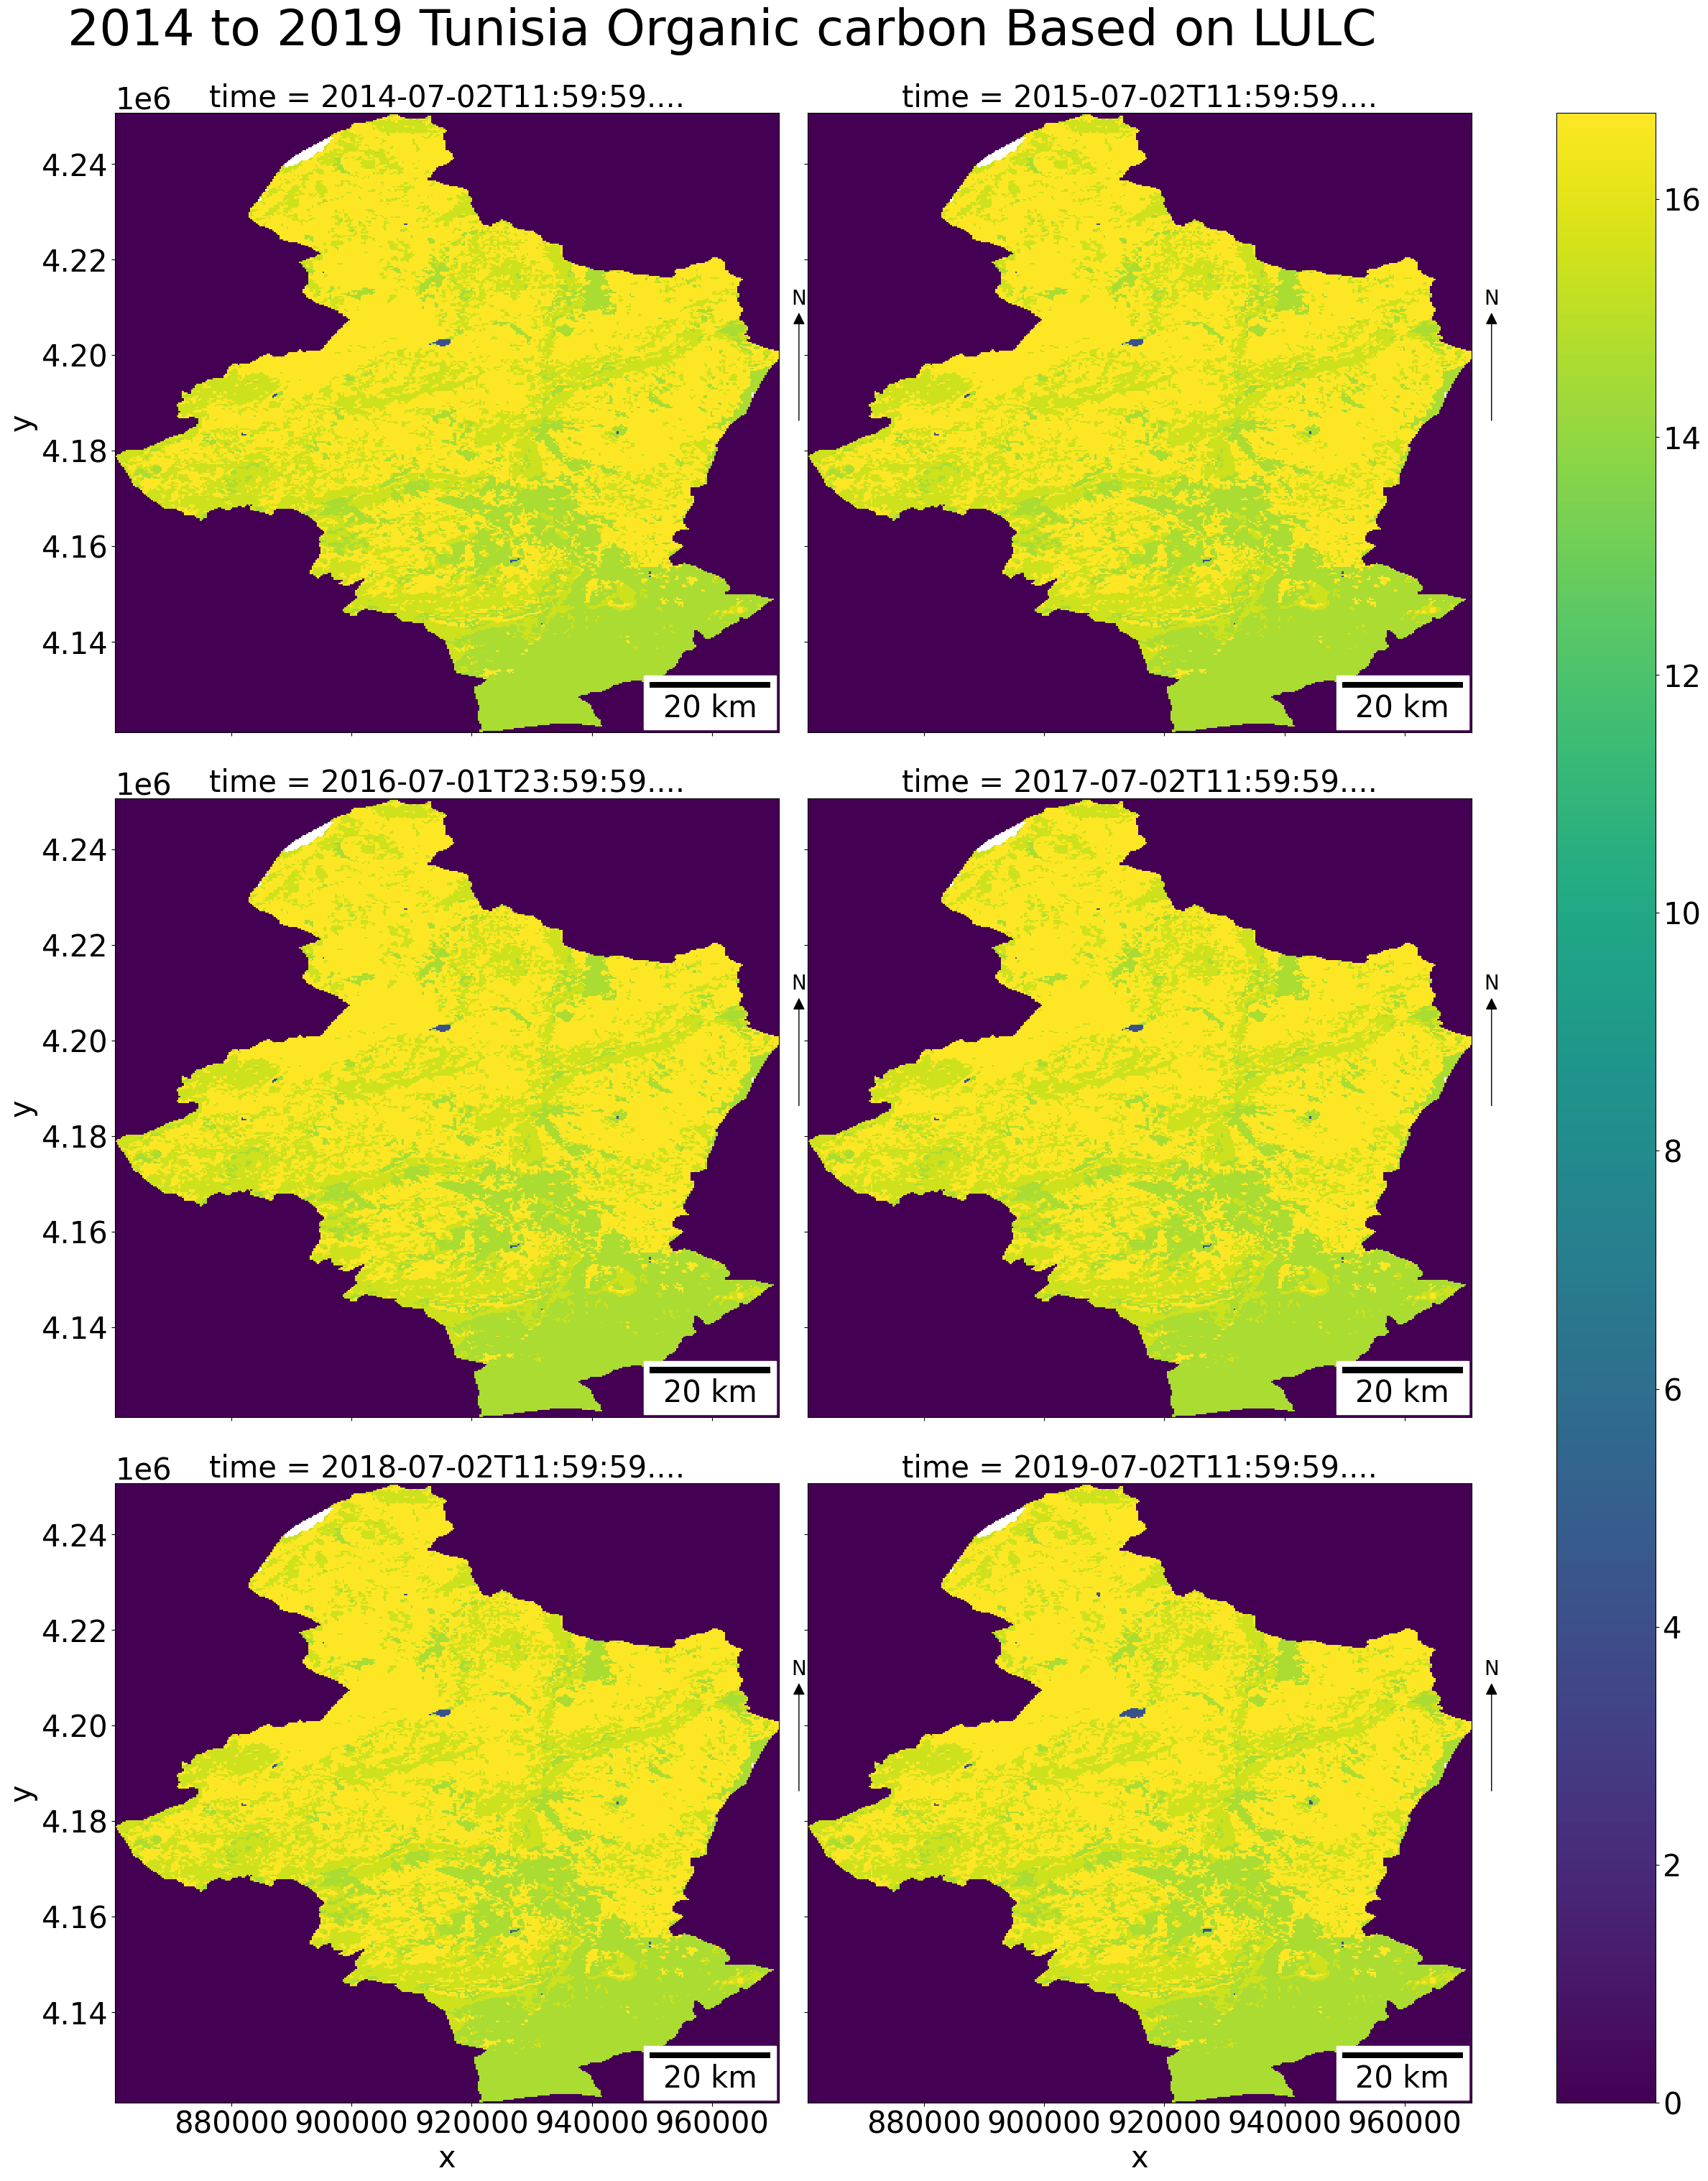

In [54]:
# Plots carbon data
fig = carbon_array.plot(col="time", col_wrap=ncols, add_colorbar=True, figsize=(figure_width, figure_length), cmap='viridis')
fig.fig.suptitle(f"2014 to 2019 {country} Organic carbon Based on LULC", x=0.4, y=1.02, size=50)

for ax in fig.axs.flat:

    ax.add_artist(ScaleBar(dx=1, location="lower right"))


    ax.annotate('N', xy=(1.03, 0.5), xytext=(1.03, 0.7),
                arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
                ha='center', va='center', fontsize=20, xycoords=ax.transAxes)
plt.show()

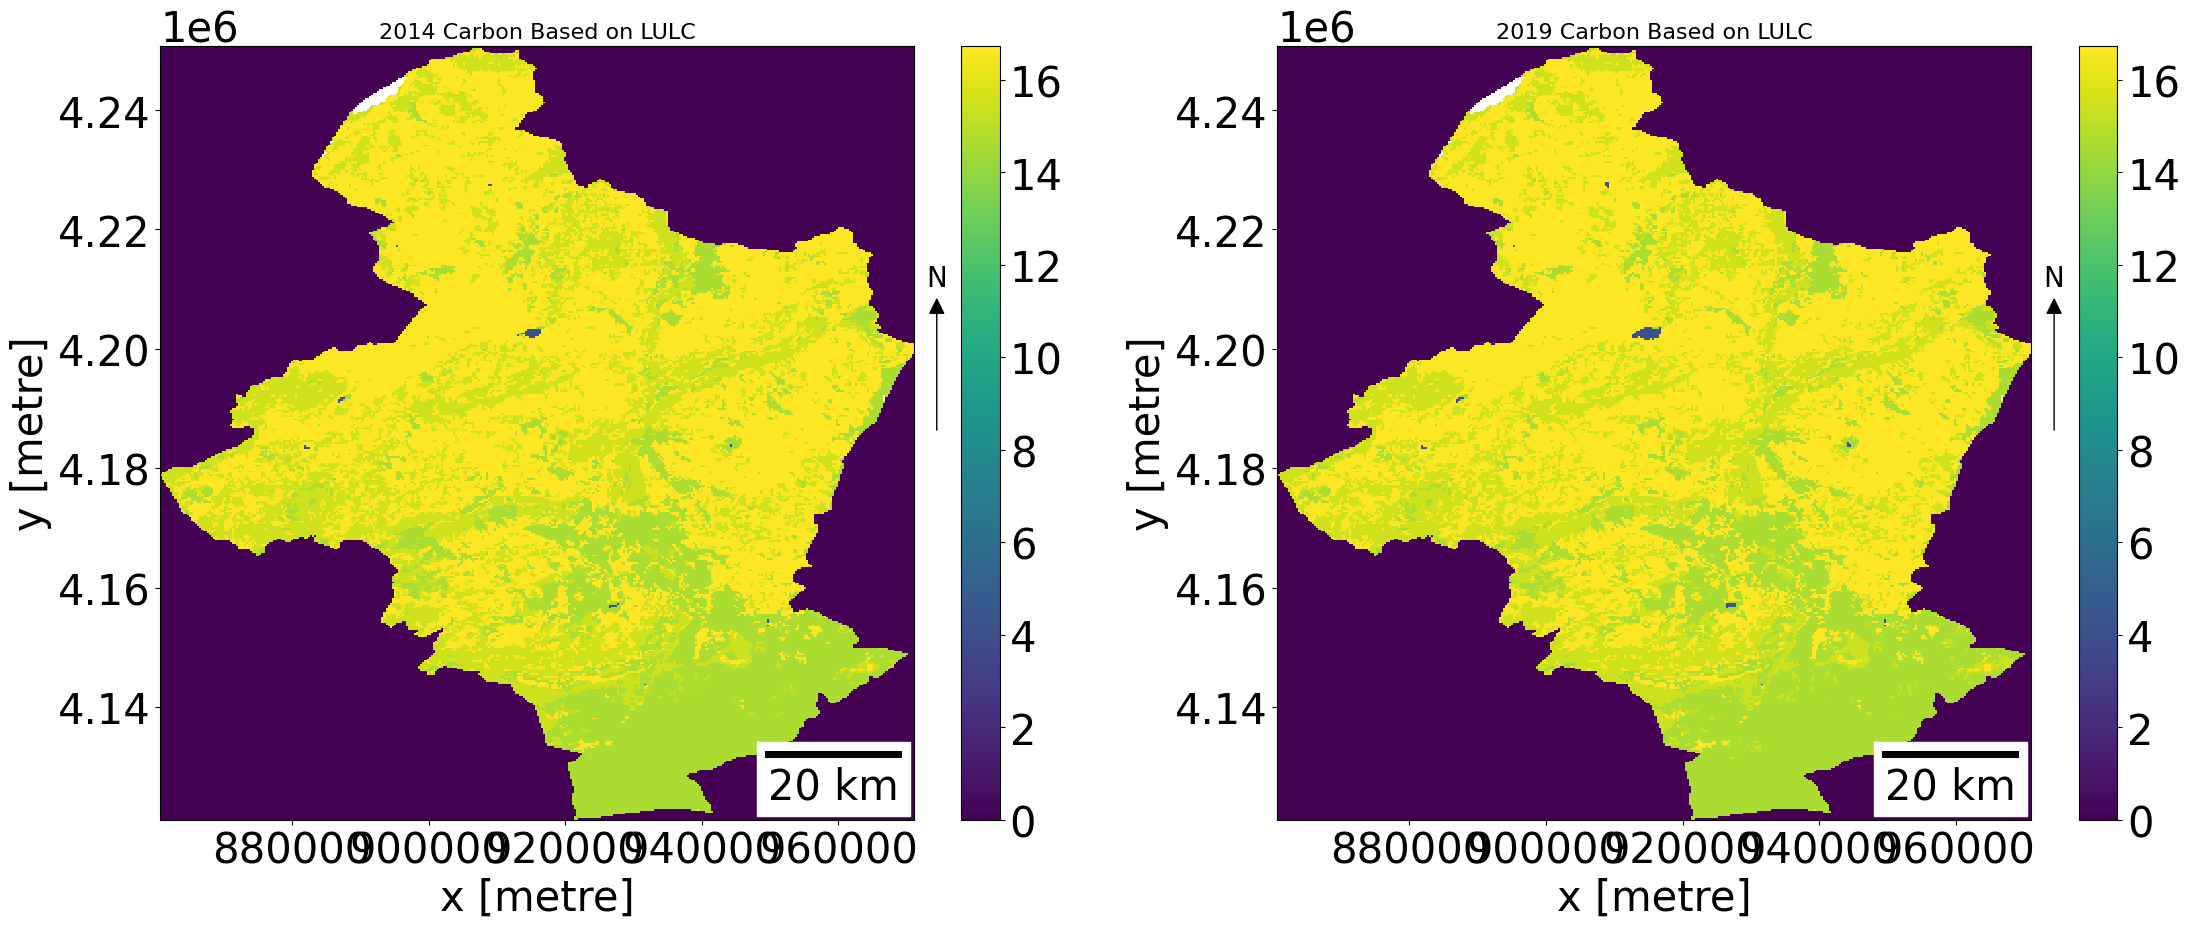

In [55]:
#Plot for 2014 and 2019
soc_2014 = carbon_array.isel(time=0)
soc_2019 = carbon_array.isel(time=-1)

plt.figure(figsize=(23, 10))

ax1 = plt.subplot(1, 2, 1)
soc_2014.squeeze().plot(cmap='viridis', add_colorbar=True, ax=ax1)
ax1.set_title("2014 Carbon Based on LULC", fontsize=16)
ax1.add_artist(ScaleBar(dx=1, location="lower right"))
ax1.annotate('N', xy=(1.03, 0.5), xytext=(1.03, 0.7),
             arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
             ha='center', va='center', fontsize=20, xycoords=ax1.transAxes)

ax2 = plt.subplot(1, 2, 2)
soc_2019.squeeze().plot(cmap='viridis', add_colorbar=True, ax=ax2)
ax2.set_title("2019 Carbon Based on LULC", fontsize=16)
ax2.add_artist(ScaleBar(dx=1, location="lower right"))
ax2.annotate('N', xy=(1.03, 0.5), xytext=(1.03, 0.7),
             arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
             ha='center', va='center', fontsize=20, xycoords=ax2.transAxes)

plt.tight_layout()
plt.show()


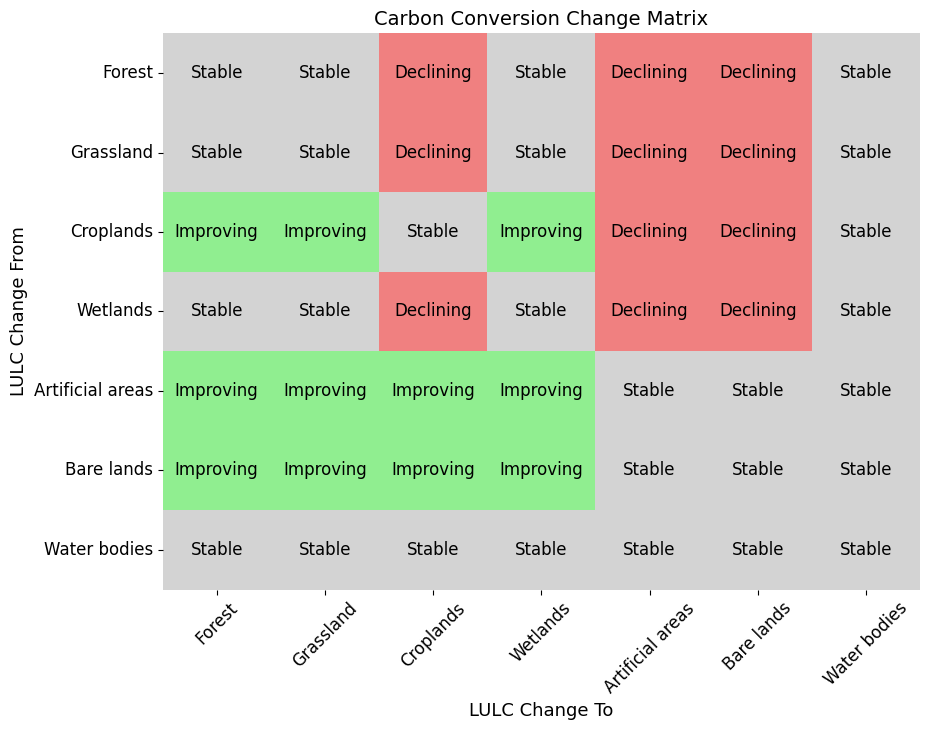

In [56]:
output_dir = './results'
country = 'Tunisia'
csv_filepath = os.path.join(output_dir, f"{country}_reference_carbon_conversion_matrix.csv")

carbon_conversion_matrix = pd.read_csv(csv_filepath)

label_to_score = {
    "Declining": -1,
    "Stable": 0,
    "Improving": 1
}

# Define the color mapping for each label
label_colors = {
    "Declining": "lightcoral",
    "Stable": "lightgray",
    "Improving": "lightgreen"
}

# Extract label matrix
labels = carbon_conversion_matrix.iloc[:, 1:]
row_labels = carbon_conversion_matrix.iloc[:, 0]
col_labels = carbon_conversion_matrix.columns[1:]

# Convert label matrix to RGB color codes using the defined color map
color_matrix = labels.replace(label_colors)

# Create a numeric matrix for plotting (placeholder, since we'll use custom colors)
numeric_dummy = np.zeros_like(labels.values, dtype=float)

# Create heatmap with custom colors and label annotations
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    numeric_dummy,
    annot=labels.values,
    fmt='',
    cmap=ListedColormap(['white']),  # base cmap, not used
    xticklabels=col_labels,
    yticklabels=row_labels,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 12, "color": "black"}
)

# Manually set background colors
for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True,
                                   color=color_matrix.iat[y, x],
                                   linewidth=0))

# Aesthetics
plt.title("Carbon Conversion Change Matrix", fontsize=14)
plt.xlabel("LULC Change To", fontsize=13)
plt.ylabel("LULC Change From", fontsize=13)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

In [65]:
tunisia_climate = 'tunisia_climate.geojson'
tunisia_climate = gpd.read_file(tunisia_climate)

In [66]:
masked_geojson = gpd.overlay(tunisia_climate, geopolygon_gdf, how='intersection')

In [67]:
masked_geojson.head()

Id  gridcode             Class  Value  country  \
0  507         5  Tropical Montane   0.64  Tunisia   
1  508         7  Tropical Montane   0.64  Tunisia   
2  531         5  Tropical Montane   0.64  Tunisia   
3  539         5  Tropical Montane   0.64  Tunisia   
4  626         4  Tropical Montane   0.64  Tunisia   

                                            geometry  
0  POLYGON ((9.37266 35.47917, 9.38333 35.48333, ...  
1  POLYGON ((9.38333 35.48333, 9.46181 35.47917, ...  
2  POLYGON ((9.31667 35.43333, 9.325 35.43333, 9....  
3  POLYGON ((9.29167 35.41667, 9.30833 35.41667, ...  
4  POLYGON ((9.15833 35.28333, 9.16667 35.28333, ...

In [68]:
f = float(masked_geojson['Value'].unique()[0])

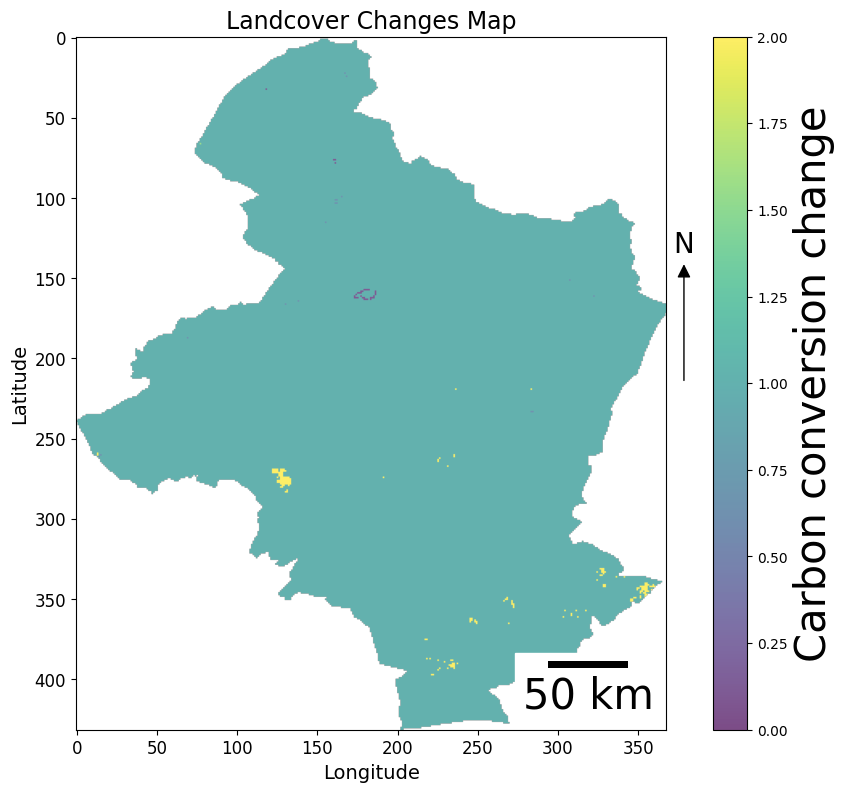

In [69]:
output_dir = './results'

lulc_2014 = ds_lulc_df.isel(time=0)
lulc_2019 = ds_lulc_df.isel(time=-1)

change_values = {
    (1, 1): 1, (1, 2): 1, (1, 3): f, (1, 4): 1, (1, 5): 0.1, (1, 6): 0.1, (1, 7): 1,
    (2, 1): 1, (2, 2): 1, (2, 3): f, (2, 4): 1, (2, 5): 0.1, (2, 6): 0.1, (2, 7): 1,
    (3, 1): 1 / f, (3, 2): 1 / f, (3, 3): 1, (3, 4): 1 / 0.71, (3, 5): 0.1, (3, 6): 0.1, (3, 7): 1,
    (4, 1): 1, (4, 2): 1, (4, 3): 0.71, (4, 4): 1, (4, 5): 0.1, (4, 6): 0.1, (4, 7): 1,
    (5, 1): 2, (5, 2): 2, (5, 3): 2, (5, 4): 2, (5, 5): 1, (5, 6): 1, (5, 7): 1,
    (6, 1): 2, (6, 2): 2, (6, 3): 2, (6, 4): 2, (6, 5): 1, (6, 6): 1, (6, 7): 1,
    (7, 1): 1, (7, 2): 1, (7, 3): 1, (7, 4): 1, (7, 5): 1, (7, 6): 1, (7, 7): 1,
}

rows, cols = lulc_2014.shape
change_map_values = np.full((rows, cols), np.nan)

for (class_2014, class_2019), value in change_values.items():
    mask = (lulc_2014 == class_2014) & (lulc_2019 == class_2019)
    change_map_values[mask] = value


plt.figure(figsize=(12, 9))
ax = plt.gca()

img = ax.imshow(change_map_values, cmap='viridis', vmin=0, vmax=np.nanmax(change_map_values), alpha=0.7)
cbar = plt.colorbar(img, ax=ax, label='Carbon conversion change')
cbar.ax.tick_params(labelsize=10)
ax.set_title("Landcover Changes Map", fontsize=17)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.tick_params(axis='both', labelsize=12)


scalebar = ScaleBar(dx=1, location="lower right", units="km")
ax.add_artist(scalebar)


ax.annotate('N', xy=(1.03, 0.5), xytext=(1.03, 0.7),
            arrowprops=dict(arrowstyle='<|-', facecolor='black'),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

output_filename = f'{country}_2014_to_2019_LULC_change_map.png'
output_path = os.path.join(output_dir, output_filename)
plt.savefig(output_path, dpi=300)


plt.show()

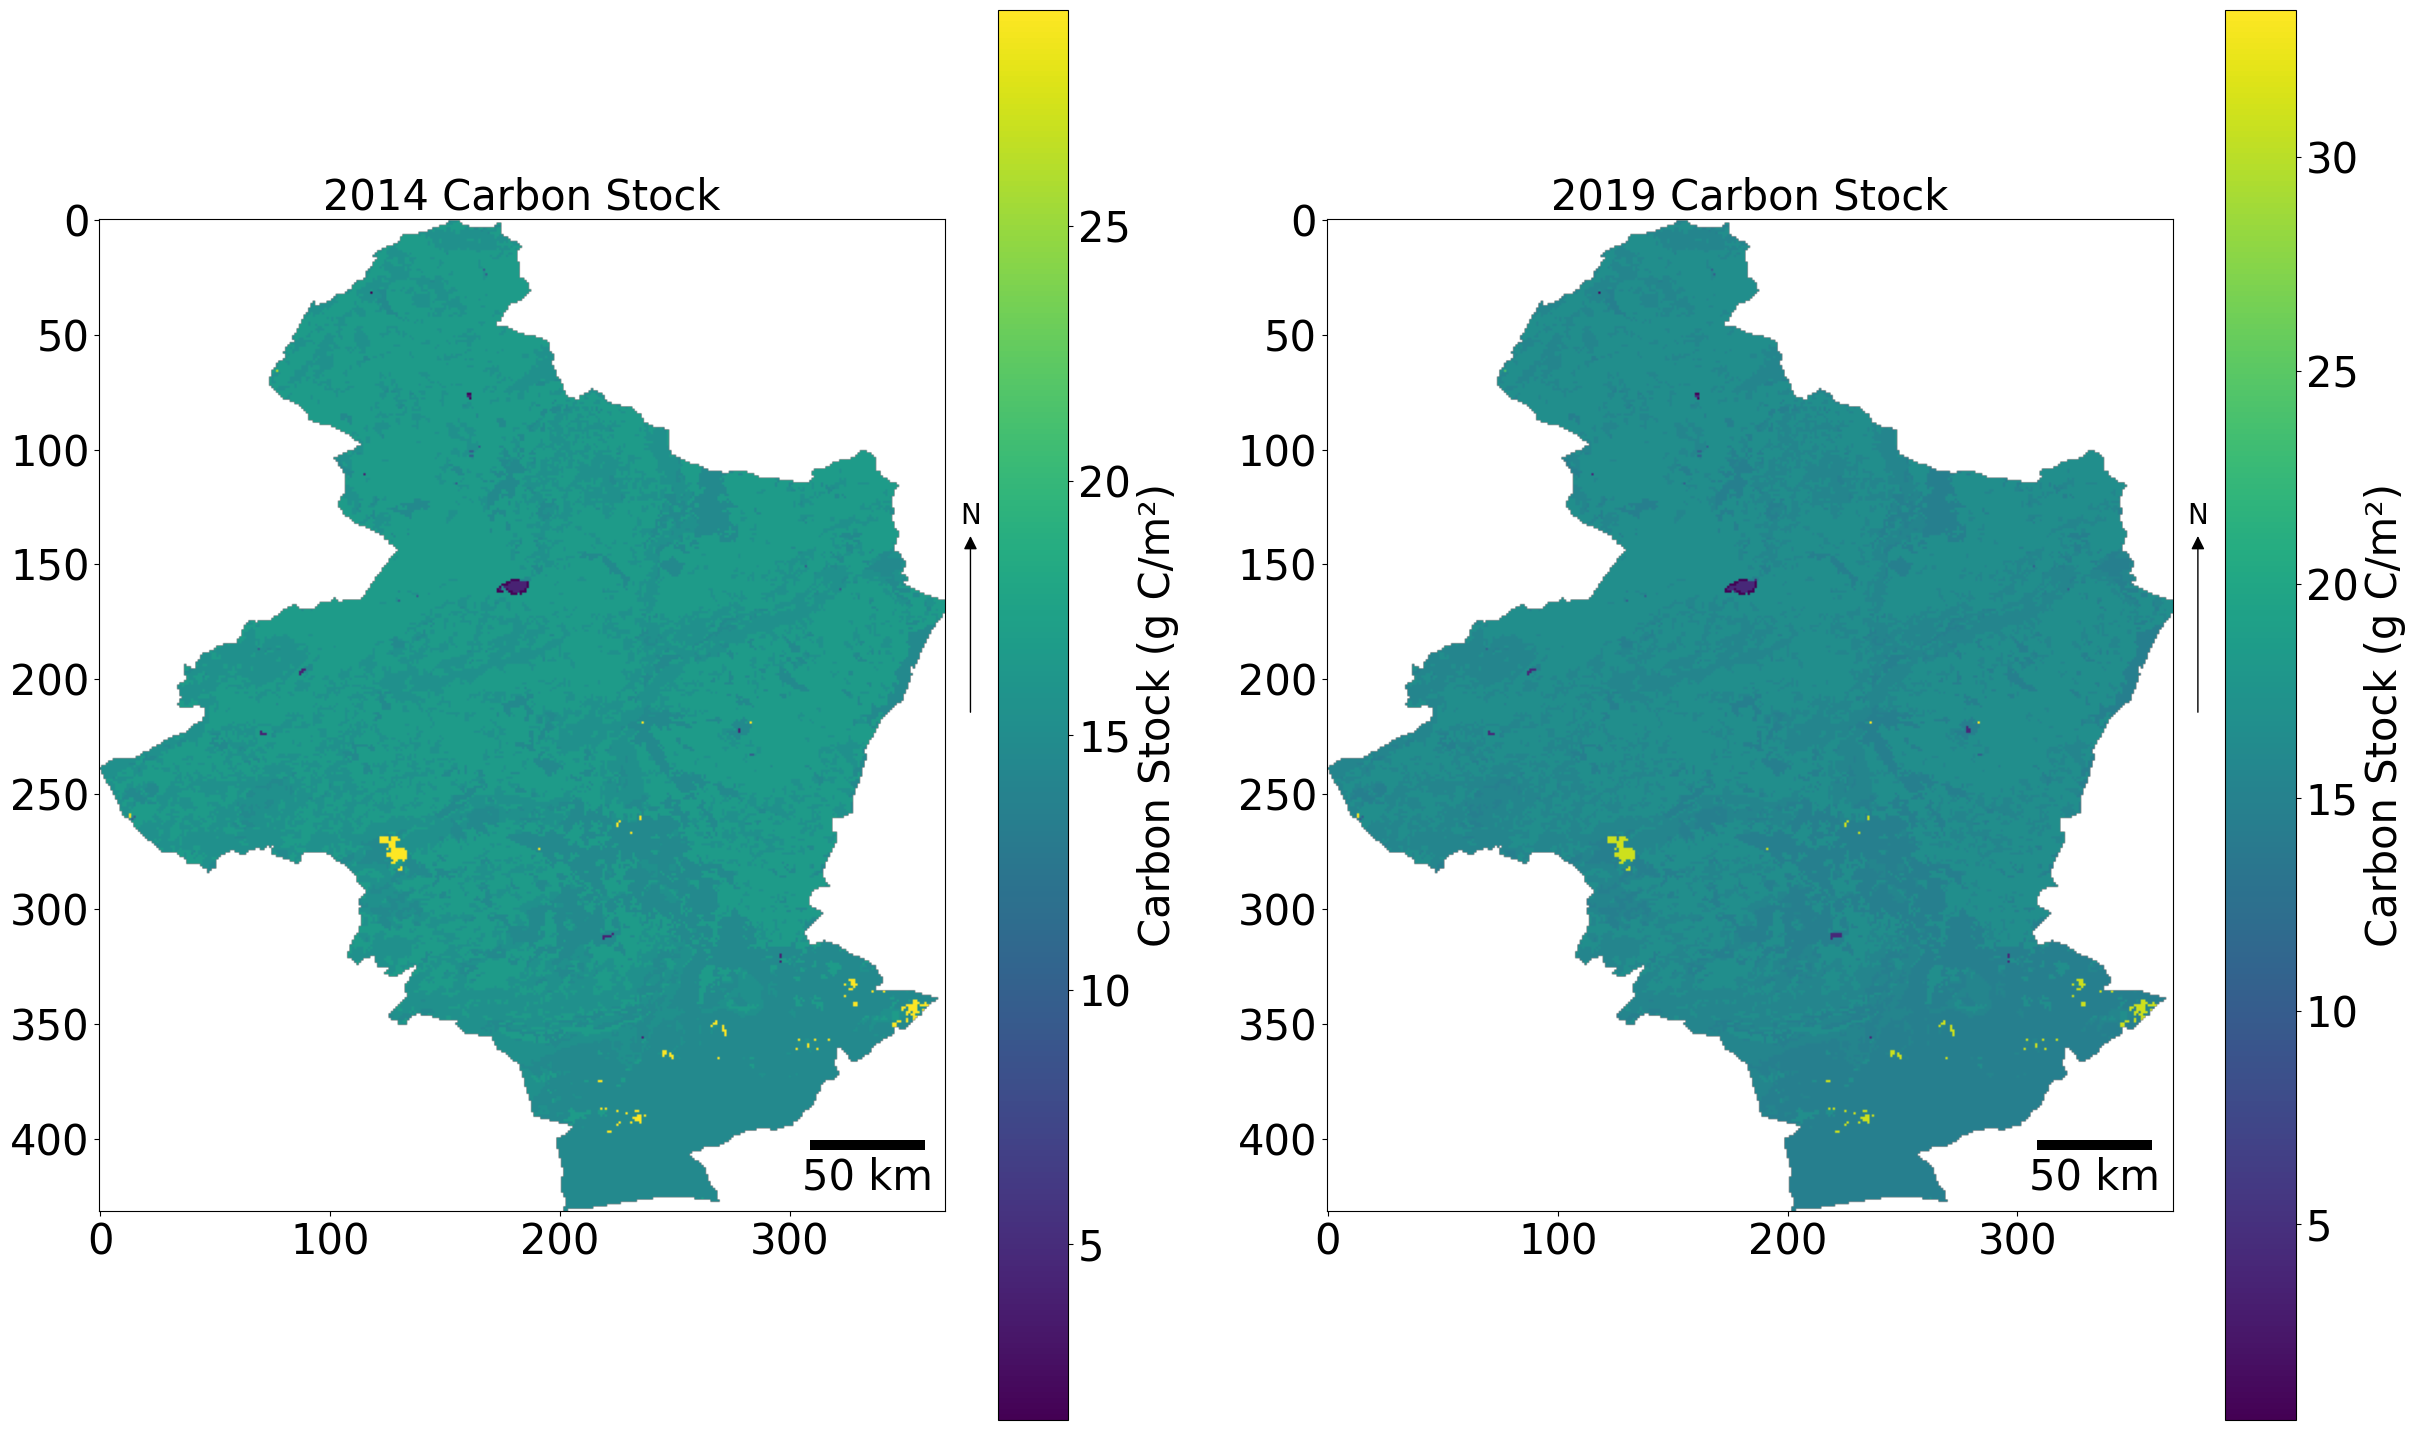

In [70]:
country = 'Tunisia'

# change_map_path = f'results/{country}_2014_to_2019_LULC_change_map.tif'
first_year_path = f'results/2014_{country}_carbon_based_on_lulc.tif'
last_year_path = f'results/2019_{country}_carbon_based_on_lulc.tif'
output_dir = './results'


# change_map = rioxarray.open_rasterio(change_map_path).squeeze()
soc_2014 = rioxarray.open_rasterio(first_year_path).squeeze()
soc_2019 = rioxarray.open_rasterio(last_year_path).squeeze()


if soc_2014.shape != change_map_values.shape:
    raise ValueError("Shape mismatch: SOC 2014 and change map must have the same dimensions.")
if soc_2019.shape != change_map_values.shape:
    raise ValueError("Shape mismatch: SOC 2019 and change map must have the same dimensions.")


carbon_stocks_2014 = soc_2014.values * change_map_values
carbon_stocks_2019 = soc_2019.values * change_map_values


output_filename_2014 = f'{country}_2014_carbon_stocks.tif'
output_filename_2019 = f'{country}_2019_carbon_stocks.tif'
output_path_2014 = os.path.join(output_dir, output_filename_2014)
output_path_2019 = os.path.join(output_dir, output_filename_2019)

fig, axs = plt.subplots(1, 2, figsize=(25, 15))

img_2014 = axs[0].imshow(carbon_stocks_2014, cmap='viridis')
cbar_2014 = fig.colorbar(img_2014, ax=axs[0], label='Carbon Stock (g C/m²)')
axs[0].set_title("2014 Carbon Stock", fontsize=30)


img_2019 = axs[1].imshow(carbon_stocks_2019, cmap='viridis')
cbar_2019 = fig.colorbar(img_2019, ax=axs[1], label='Carbon Stock (g C/m²)')
axs[1].set_title("2019 Carbon Stock", fontsize=30)

for ax in axs.flat:

    ax.add_artist(ScaleBar(dx=1, location="lower right", units="km"))

    # Add a north arrow
    ax.annotate('N', xy=(1.03, 0.5), xytext=(1.03, 0.7),
                arrowprops=dict(arrowstyle='<|-', facecolor='black'),
                ha='center', va='center', fontsize=20, xycoords='axes fraction')

plt.tight_layout()

plt.show()

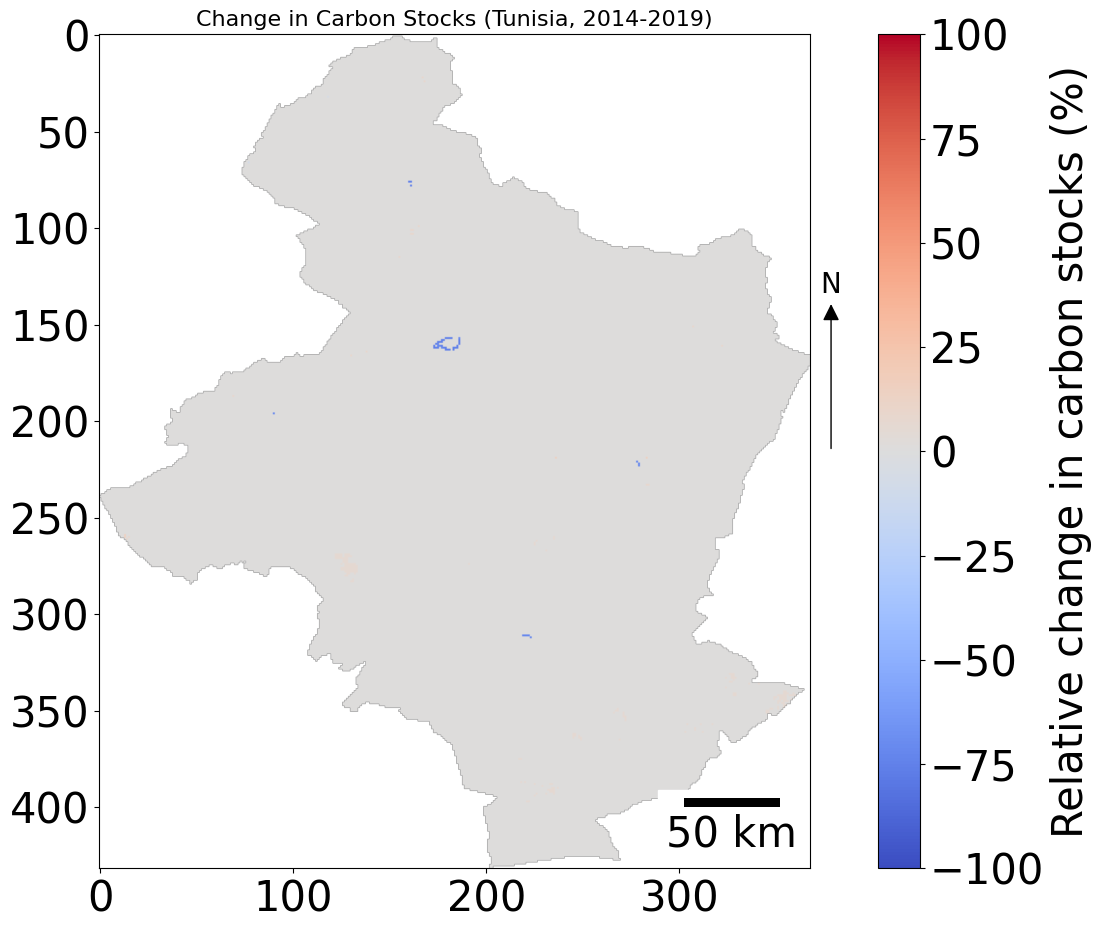

In [71]:
soc_2014 = carbon_stocks_2014
soc_2019 = carbon_stocks_2019

if soc_2014.shape != soc_2019.shape:
    raise ValueError("Shape mismatch: SOC 2014 and SOC 2019 must have the same dimensions.")

change_in_soc = soc_2019 - soc_2014

relative_change = (change_in_soc / soc_2014) * 100

change_classification = np.zeros_like(relative_change)

change_classification[relative_change >= 10] = 1
change_classification[relative_change <= -10] = -1

output_classification_filename = f'./results/{country}_2014_2019_carbon_stock_change_classification.tif'

classification_rio = xr.DataArray(change_classification,
                                   coords={'y': ds_lulc.coords['y'],
                                           'x': ds_lulc.coords['x']},
                                   dims=['y', 'x'])

classification_rio.rio.write_crs(ds_lulc.rio.crs, inplace=True)
classification_rio.rio.write_transform(ds_lulc.rio.transform(), inplace=True)

classification_rio.rio.to_raster(output_classification_filename)

plt.figure(figsize=(15, 10))

plt.subplot(1, 1, 1)
plt.imshow(relative_change, cmap='coolwarm', vmin=-100, vmax=100)
plt.colorbar(label='Relative change in carbon stocks (%)')
plt.title(f'Change in Carbon Stocks ({country}, 2014-2019)', fontsize=16)

ax = plt.gca()  # Get current axes
ax.add_artist(ScaleBar(dx=1, units="km", location="lower right"))  # Adjust dx if necessary
ax.annotate('N', xy=(1.03, 0.5), xytext=(1.03, 0.7),
            arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)

plt.tight_layout()
plt.show()

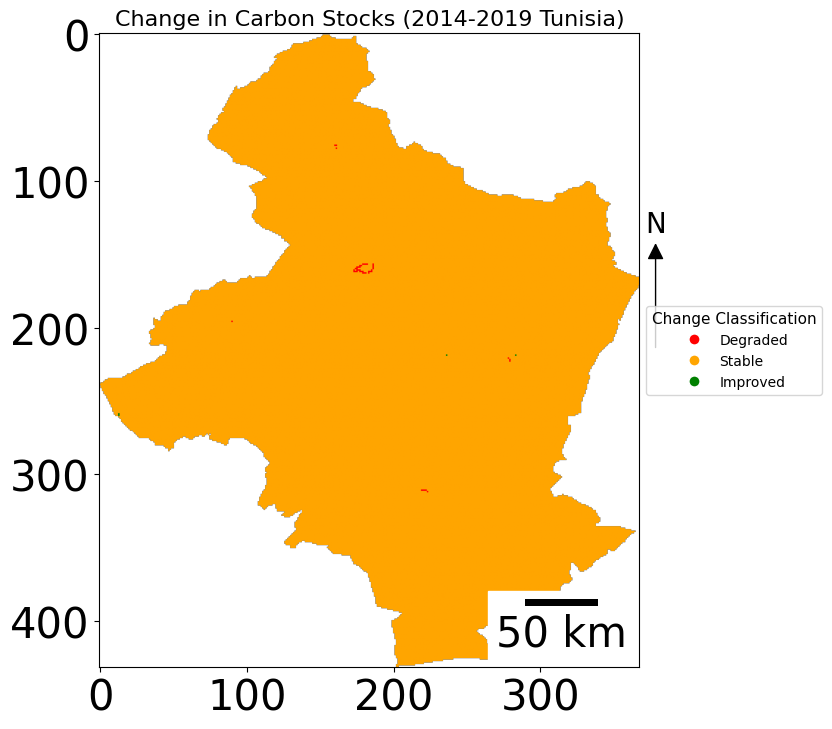

In [72]:
soc_2014 = carbon_stocks_2014
soc_2019 = carbon_stocks_2019
# Check if the two datasets have the same shape
if soc_2014.shape != soc_2019.shape:
    raise ValueError("Shape mismatch: SOC 2014 and SOC 2019 must have the same dimensions.")
# Calculate the change in SOC by subtracting 2014 from 2019 values
change_in_soc = soc_2019 - soc_2014
# Calculate the relative percentage change in SOC between the two years
relative_change = (change_in_soc / soc_2014) * 100

# Initialize an array to classify the SOC change into three categories (Improved, Stable, Degraded)
change_classification = np.zeros_like(relative_change)
change_classification[relative_change >= 10] = 1
change_classification[relative_change <= -10] = -1
# Create a mask to exclude areas where SOC is non-positive (no SOC data)
mask = (soc_2014 > 0)
change_classification[~mask] = np.nan
# Define the initial and follow-up years for the output file name
initial_year = 2014
followup_year = 2019
output_classification_filename = f'./results/{country}_SOC_changes_Map.tif'
# Convert the classification array
classification_rio = xr.DataArray(change_classification,
                                   coords={'y': ds_lulc.coords['y'],
                                           'x': ds_lulc.coords['x']},
                                   dims=['y', 'x'])

classification_rio.rio.write_crs(ds_lulc.rio.crs, inplace=True)
classification_rio.rio.write_transform(ds_lulc.rio.transform(), inplace=True)

classification_rio.rio.to_raster(output_classification_filename)

plt.figure(figsize=(12, 8))

change_colors = ['red', 'orange', 'green']
change_classes = [-1, 0, 1]
cmap = mcolors.ListedColormap(change_colors)
bounds = np.arange(min(change_classes) - 0.5, max(change_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Display the change classification map with the defined colormap and normalization
plt.imshow(change_classification, cmap=cmap, norm=norm)

plt.title(f'Change in Carbon Stocks ({initial_year}-{followup_year} {country})', fontsize=16)

legend_labels = ['Degraded', 'Stable', 'Improved']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                       markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, change_colors)]

plt.legend(handles=handles, title='Change Classification', loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize=10, title_fontsize='11', framealpha=0.8)

ax = plt.gca()
ax.add_artist(ScaleBar(dx=1, units="km", location="lower right"))
ax.annotate('N', xy=(1.03, 0.5), xytext=(1.03, 0.7),
            arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)


plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()